# **Problem Statement:**

In the financial industry, accurately assessing the creditworthiness of individuals is crucial for mitigating risk and ensuring responsible lending practices. Traditional methods of credit score prediction often rely on historical credit data, which may not fully capture the evolving financial behavior of individuals. This project aims to develop a robust classification model that predicts an individual's credit score based on various features, including transaction history, payment patterns, and demographic information.

# **Objective:**

The primary challenge is to build a robust model that can classify credit scores into predefined categories (e.g., Standard, Good, Poor) with high accuracy. This model should leverage a diverse set of features to predict credit scores and provide actionable insights that can help financial institutions make informed lending decisions.

# **About Dataset:**

ID                          
Customer_ID                 
Month                     
Name                       
Age                       
SSN                       
Occupation                 
Annual_Income             
Monthly_Inhand_Salary     
Num_Bank_Accounts         
Num_Credit_Card           
Interest_Rate             
Num_of_Loan               
Type_of_Loan               
Delay_from_due_date       
Num_of_Delayed_Payment    
Changed_Credit_Limit      
Num_Credit_Inquiries      
Credit_Mix                 
Outstanding_Debt          
Credit_Utilization_Ratio  
Credit_History_Age        
Payment_of_Min_Amount      
Total_EMI_per_month       
Amount_invested_monthly   
Payment_Behaviour          
Monthly_Balance           
Credit_Score              

# Load the libraries

In [ ]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
!pip install association-metrics -q

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install gdown -q

In [ ]:
import numpy as np
import pandas as pd
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import association_metrics as am
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split
import optuna
from optuna import Trial
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
from google.colab import drive
import joblib

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


# Load the dataset

In [ ]:
url = f'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D
To: /content/dataset.csv
100%|██████████| 30.2M/30.2M [00:00<00:00, 67.9MB/s]


# Looking into the data

In [ ]:
data.sample(5)

ID  Customer_ID  Month             Name   Age          SSN  \
34515   57405        36488      4       Huw Jonesj  29.0  528987663.0   
70176  110898        38770      1          Alexeih  30.0   73040918.0   
97234  151484         1935      3  rian Ellsworthm  43.0  351753508.0   
8405    18239        22087      6         Soyoungh  41.0  365069242.0   
73510  115896        22056      7           Alperw  35.0  208750668.0   

          Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
34515       Engineer      58074.150            4881.512500                8.0   
70176         Doctor      51582.540            4016.545000                3.0   
97234   Entrepreneur      12804.965             771.080417                3.0   
8405          Lawyer      79367.940            6535.995000                3.0   
73510  Media_Manager       8858.405            1022.200417                6.0   

       ...  Credit_Mix  Outstanding_Debt  Credit_Utilization_Ratio  \
34515  ...         Bad           2829.78                 36.464423   
70176  ...    Standard           1354.35                 35.498516   
97234  ...    Standard            436.63                 36.808653   
8405   ...    Standard           1137.41                 33.356321   
73510  ...    Standard           2431.08                 28.165542   

      Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
34515              119.0                    Yes           207.669343   
70176              297.0                     NM            35.857520   
97234              155.0                    Yes            11.203035   
8405               279.0                    Yes             0.000000   
73510              173.0                    Yes             8.562245   

       Amount_invested_monthly                 Payment_Behaviour  \
34515                68.418758    Low_spent_Large_value_payments   
70176                32.898787  High_spent_Medium_value_payments   
97234                17.001988   Low_spent_Medium_value_payments   
8405                 80.658608   Low_spent_Medium_value_payments   
73510                11.051943    Low_spent_Large_value_payments   

      Monthly_Balance  Credit_Score  
34515      117.178692      Standard  
70176      539.805145      Standard  
97234      278.159219      Standard  
8405       290.912188          Good  
73510      332.664836      Standard  

[5 rows x 28 columns]

In [ ]:
data.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score'],
      dtype='object')

In [ ]:
data.shape

(100000, 28)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [ ]:
data.describe()

ID    Customer_ID          Month            Age  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    80631.500000   25982.666640       4.500000      33.316340   
std     43301.486619   14340.543051       2.291299      10.764812   
min      5634.000000    1006.000000       1.000000      14.000000   
25%     43132.750000   13664.500000       2.750000      24.000000   
50%     80631.500000   25777.000000       4.500000      33.000000   
75%    118130.250000   38385.000000       6.250000      42.000000   
max    155629.000000   50999.000000       8.000000      56.000000   

                SSN  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  1.000000e+05  100000.000000          100000.000000      100000.000000   
mean   5.004617e+08   50505.123449            4197.270835           5.368820   
std    2.908267e+08   38299.422093            3186.432497           2.593314   
min    8.134900e+04    7005.930000             303.645417           0.000000   
25%    2.451686e+08   19342.972500            1626.594167           3.000000   
50%    5.006886e+08   36999.705000            3095.905000           5.000000   
75%    7.560027e+08   71683.470000            5957.715000           7.000000   
max    9.999934e+08  179987.280000           15204.633333          11.000000   

       Num_Credit_Card  Interest_Rate  ...  Delay_from_due_date  \
count    100000.000000   100000.00000  ...         100000.00000   
mean          5.533570       14.53208  ...             21.08141   
std           2.067098        8.74133  ...             14.80456   
min           0.000000        1.00000  ...              0.00000   
25%           4.000000        7.00000  ...             10.00000   
50%           5.000000       13.00000  ...             18.00000   
75%           7.000000       20.00000  ...             28.00000   
max          11.000000       34.00000  ...             62.00000   

       Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
count           100000.000000         100000.000000         100000.000000   
mean                13.313120             10.470323              5.798250   
std                  6.237166              6.609481              3.867826   
min                  0.000000              0.500000              0.000000   
25%                  9.000000              5.380000              3.000000   
50%                 14.000000              9.400000              5.000000   
75%                 18.000000             14.850000              8.000000   
max                 25.000000             29.980000             17.000000   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
count     100000.000000             100000.000000       100000.000000   
mean        1426.220376                 32.285173          221.220460   
std         1155.129026                  5.116875           99.680716   
min            0.230000                 20.000000            1.000000   
25%          566.072500                 28.052567          144.000000   
50%         1166.155000                 32.305784          219.000000   
75%         1945.962500                 36.496663          302.000000   
max         4998.070000                 50.000000          404.000000   

       Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance  
count        100000.000000            100000.000000    100000.000000  
mean            107.699208                55.101315       392.697586  
std             132.267056                39.006932       201.652719  
min               0.000000                 0.000000         0.007760  
25%              29.268886                27.959111       267.615983  
50%              66.462304                45.156550       333.865366  
75%             147.392573                71.295797       463.215683  
max            1779.103254               434.191089      1183.930696  

[8 rows x 21 columns]

In [ ]:
data.nunique()

ID                          100000
Customer_ID                  12500
Month                            8
Name                         10128
Age                             43
SSN                          12500
Occupation                      15
Annual_Income                12488
Monthly_Inhand_Salary        13241
Num_Bank_Accounts               12
Num_Credit_Card                 12
Interest_Rate                   34
Num_of_Loan                     10
Type_of_Loan                  6261
Delay_from_due_date             63
Num_of_Delayed_Payment          26
Changed_Credit_Limit          3452
Num_Credit_Inquiries            18
Credit_Mix                       3
Outstanding_Debt             12203
Credit_Utilization_Ratio    100000
Credit_History_Age             404
Payment_of_Min_Amount            3
Total_EMI_per_month          11890
Amount_invested_monthly      12261
Payment_Behaviour                6
Monthly_Balance              98494
Credit_Score                     3
dtype: int64

# Exploratory Data Analysis

In [ ]:
data["Credit_Score"].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [ ]:
data['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      28580
High_spent_Medium_value_payments    18988
Low_spent_Medium_value_payments     14962
High_spent_Large_value_payments     14639
High_spent_Small_value_payments     12043
Low_spent_Large_value_payments      10788
Name: count, dtype: int64

In [ ]:
data["Month"].value_counts()

Month
1    12500
2    12500
3    12500
4    12500
5    12500
6    12500
7    12500
8    12500
Name: count, dtype: int64

In [ ]:
data["Occupation"].value_counts()

Occupation
Lawyer           7096
Engineer         6864
Architect        6824
Mechanic         6776
Scientist        6744
Accountant       6744
Developer        6720
Media_Manager    6720
Teacher          6672
Entrepreneur     6648
Doctor           6568
Journalist       6536
Manager          6432
Musician         6352
Writer           6304
Name: count, dtype: int64

In [ ]:
data["Num_Bank_Accounts"].value_counts()

Num_Bank_Accounts
6.0     13175
7.0     12999
8.0     12940
4.0     12343
5.0     12298
3.0     12107
9.0      5503
10.0     5329
1.0      4540
0.0      4417
2.0      4340
11.0        9
Name: count, dtype: int64

In [ ]:
data["Num_Credit_Card"].value_counts()

Num_Credit_Card
5.0     18903
7.0     17024
6.0     16932
4.0     14362
3.0     13560
8.0      5073
10.0     4962
9.0      4753
2.0      2196
1.0      2185
11.0       36
0.0        14
Name: count, dtype: int64

In [ ]:
data["Num_of_Loan"].value_counts()

Num_of_Loan
3.0    15752
2.0    15712
4.0    15456
0.0    11408
1.0    11128
6.0     8144
7.0     7680
5.0     7528
9.0     3856
8.0     3336
Name: count, dtype: int64

In [ ]:
data["Credit_Mix"].value_counts()

Credit_Mix
Standard    45848
Good        30384
Bad         23768
Name: count, dtype: int64

In [ ]:
data["Payment_of_Min_Amount"].value_counts()

Payment_of_Min_Amount
Yes    52326
No     35667
NM     12007
Name: count, dtype: int64

In [ ]:
data["Type_of_Loan"].value_counts()

Type_of_Loan
No Data                                                                                                                     11408
not specified                                                                                                                1408
credit-builder loan                                                                                                          1280
personal loan                                                                                                                1272
debt consolidation loan                                                                                                      1264
                                                                                                                            ...  
not specified,mortgage loan,auto loan,payday loan                                                                               8
payday loan,mortgage loan,debt consolidation loan,student loan               

In [ ]:
data["Changed_Credit_Limit"].value_counts()

Changed_Credit_Limit
8.22     137
11.50    128
11.32    127
7.35     124
10.06    124
        ... 
1.72       1
24.19      1
26.80      1
22.88      1
21.17      1
Name: count, Length: 3452, dtype: int64

## Heatmap of Credit Score by Occupation

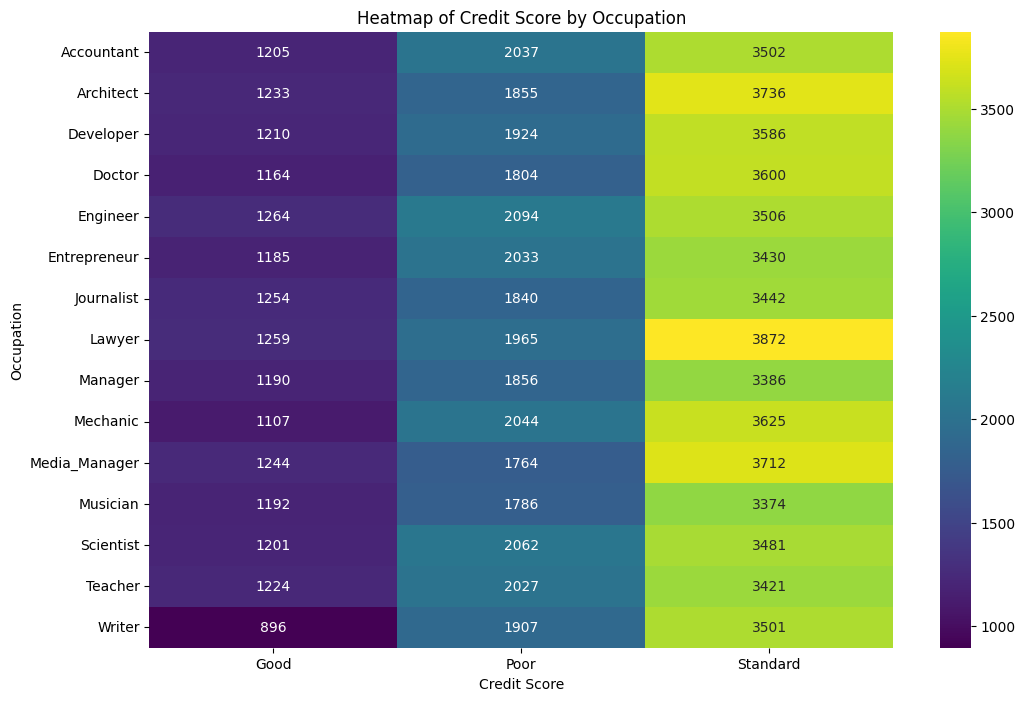

In [ ]:
cross_tab = pd.crosstab(data['Occupation'], data['Credit_Score'])

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='viridis', fmt='d')

plt.xlabel('Credit Score')
plt.ylabel('Occupation')
plt.title('Heatmap of Credit Score by Occupation')
plt.show()

## Distribution of Age by Credit Score Category

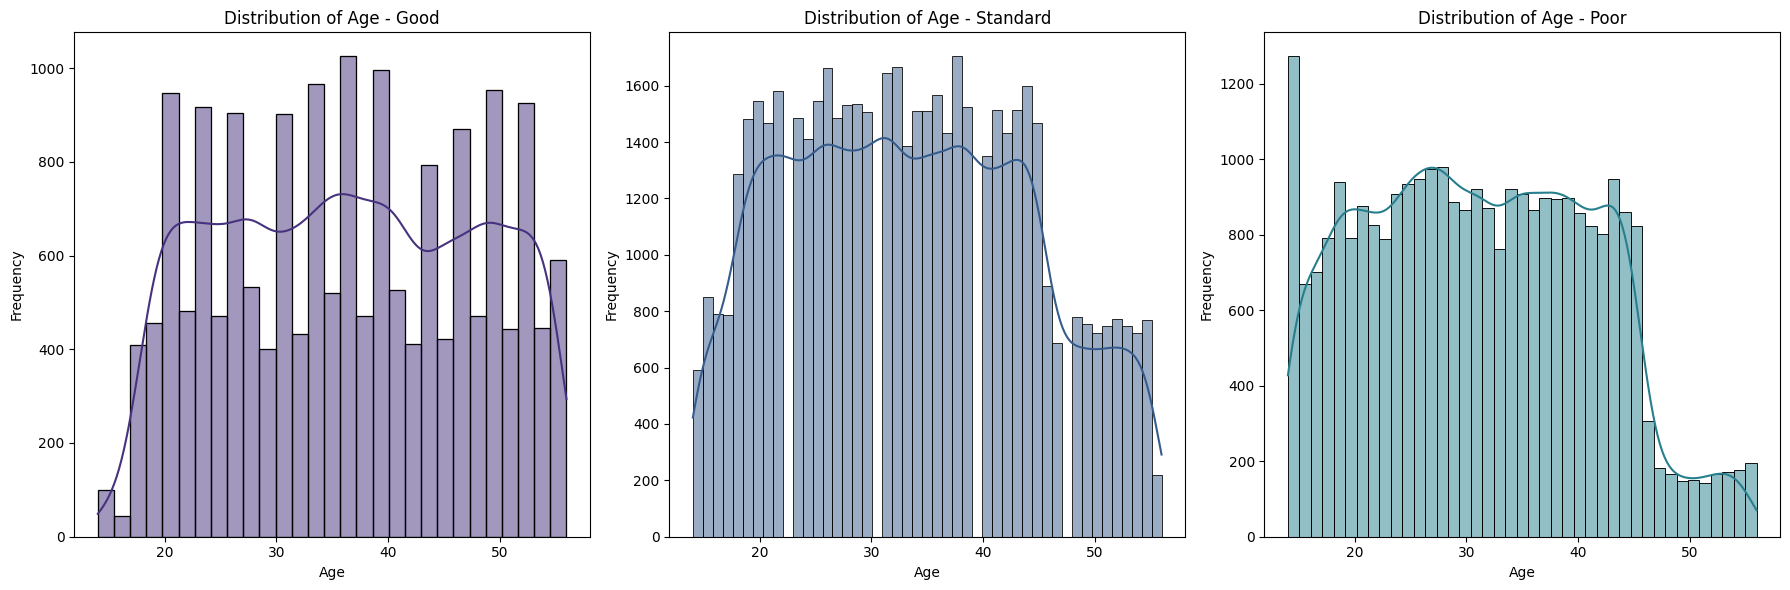

In [ ]:
plt.figure(figsize=(18, 6))

categories = ['Good', 'Standard', 'Poor']

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Age'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Age - {category}')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Box Plot of Annual Income by Credit Score Category

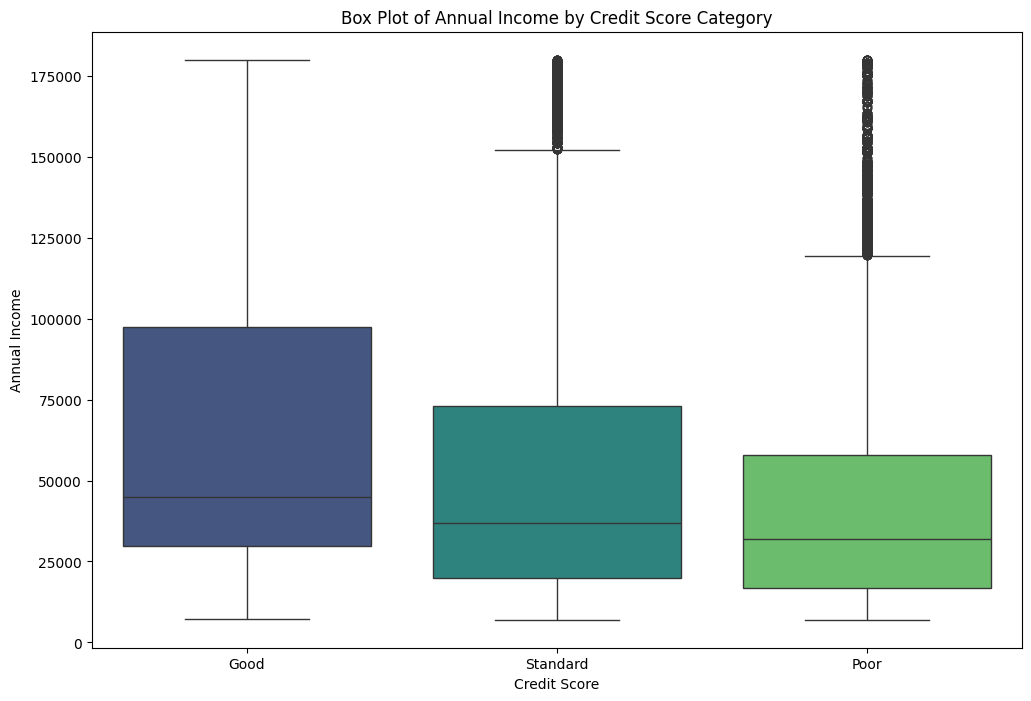

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=data, x='Credit_Score', y='Annual_Income', palette='viridis')

plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.title('Box Plot of Annual Income by Credit Score Category')
plt.show()

## Distribution of Annual Income by Credit Score Category

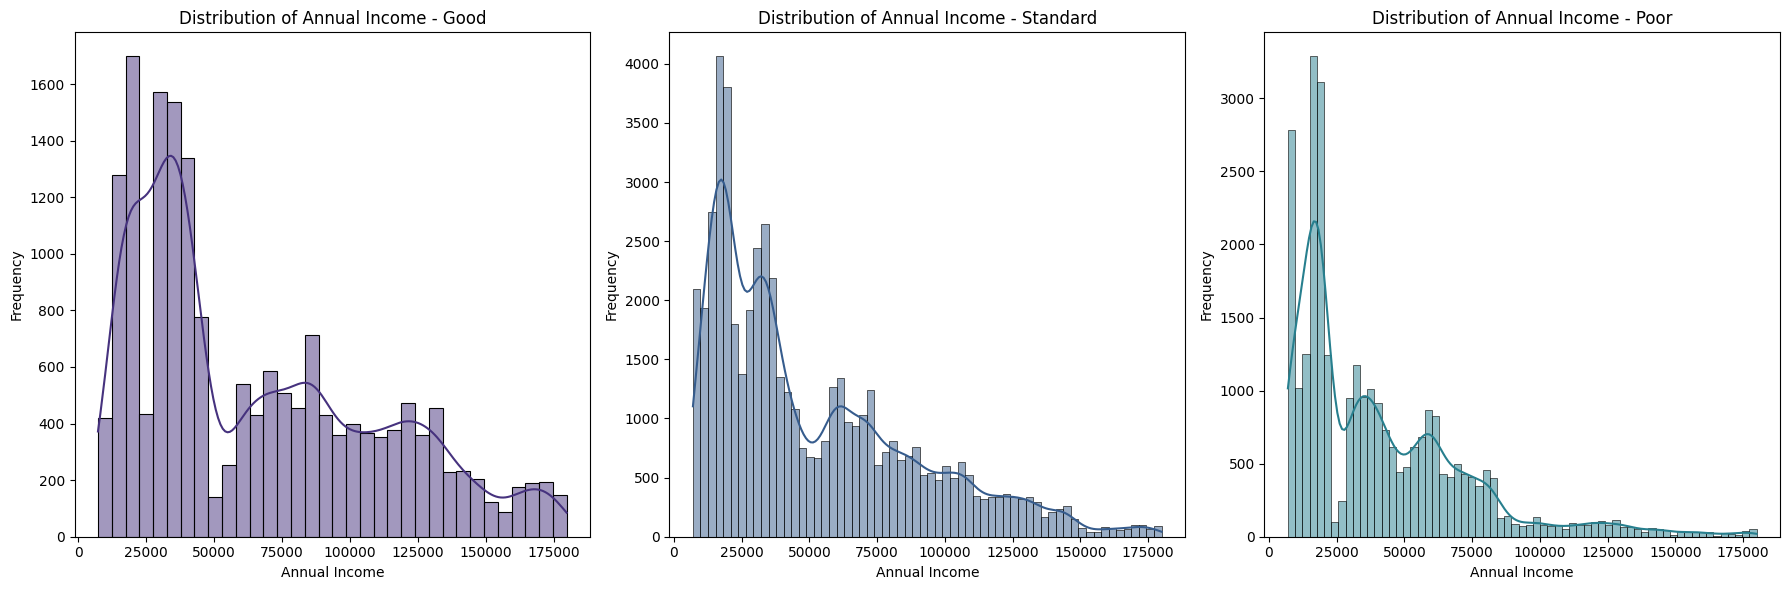

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Annual_Income'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Annual Income - {category}')
    plt.xlabel('Annual Income')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Box Plot of Monthly Inhand Salary by Credit Score Category

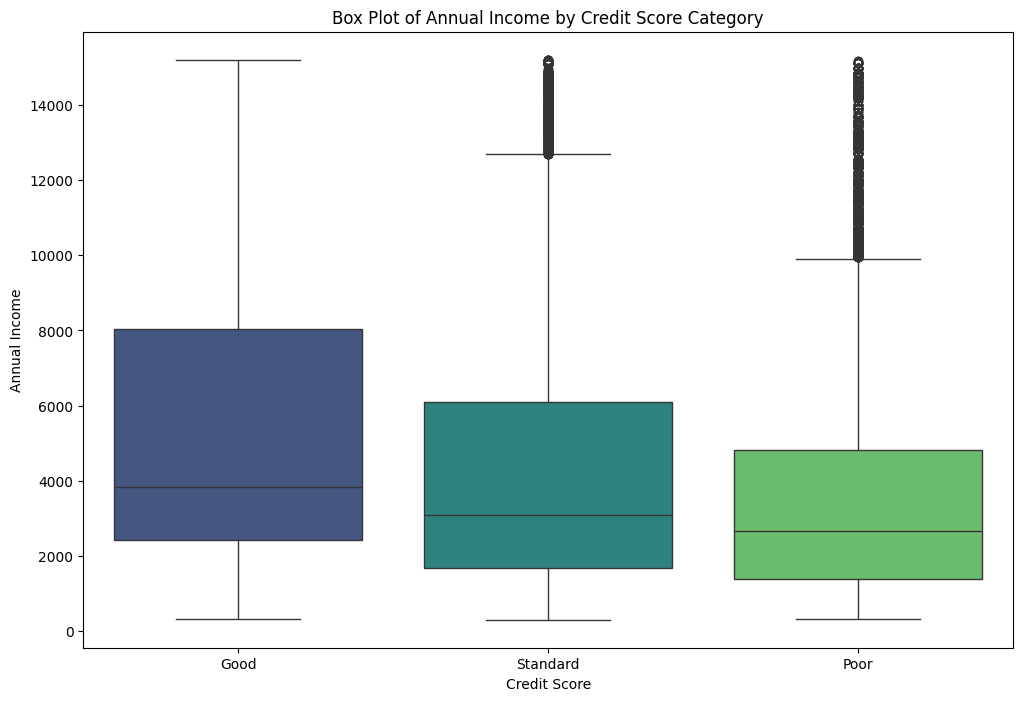

In [ ]:
plt.figure(figsize=(12, 8))

sns.boxplot(data=data, x='Credit_Score', y='Monthly_Inhand_Salary', palette='viridis')

plt.xlabel('Credit Score')
plt.ylabel('Annual Income')
plt.title('Box Plot of Annual Income by Credit Score Category')
plt.show()

## Distribution of Monthly Inhand Salary by Credit Score Category

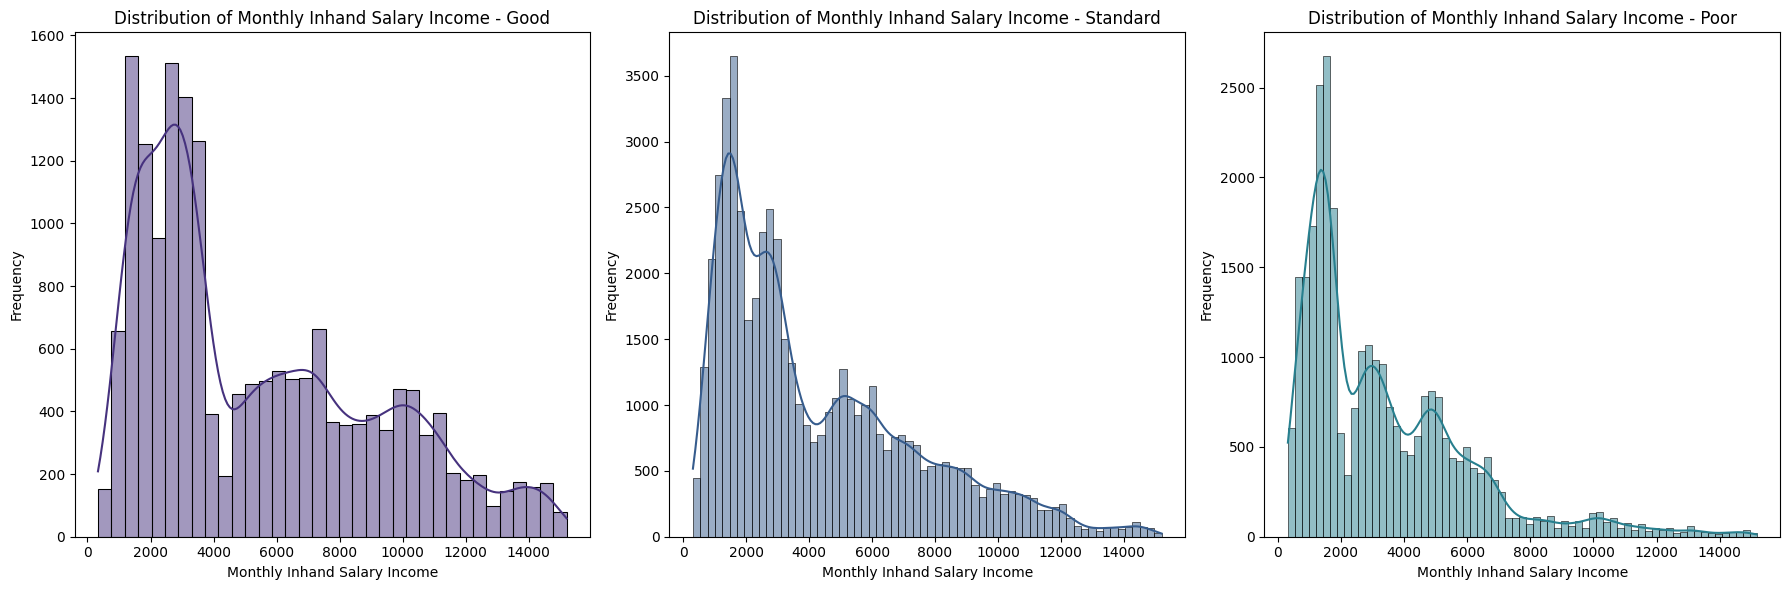

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Monthly_Inhand_Salary'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Monthly Inhand Salary Income - {category}')
    plt.xlabel('Monthly Inhand Salary Income')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Bank Accounts by Credit Score Category

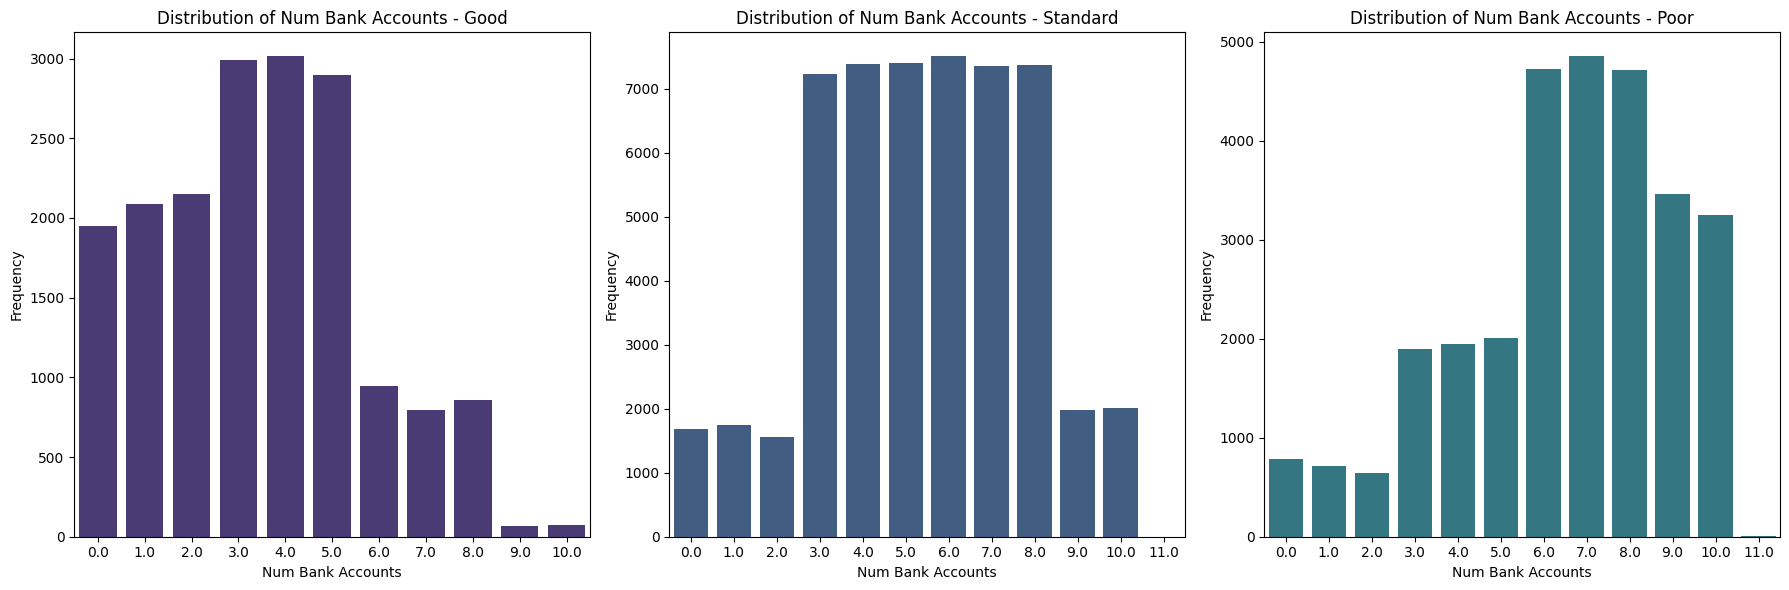

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Bank_Accounts'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Bank_Accounts'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num Bank Accounts - {category}')
    plt.xlabel('Num Bank Accounts')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Credit Card by Credit Score Category

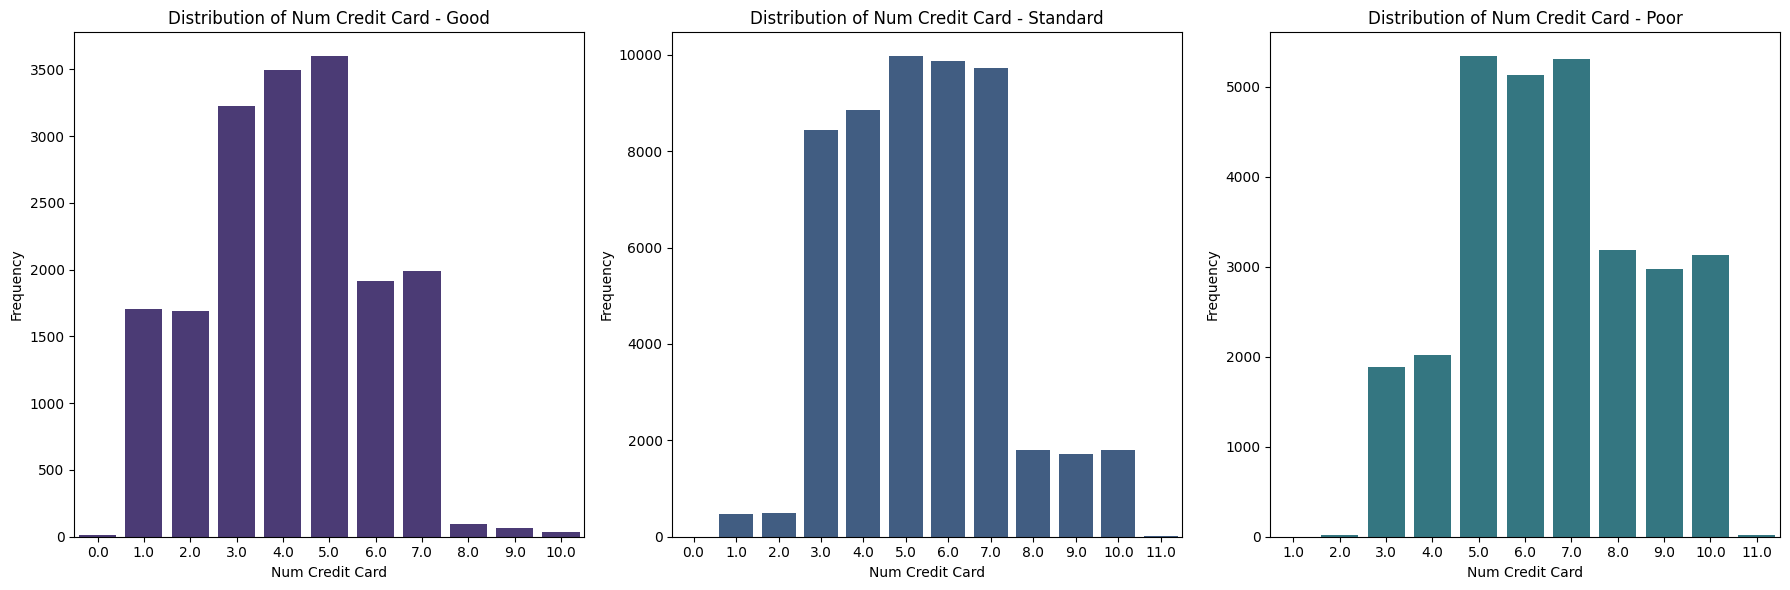

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Credit_Card'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Credit_Card'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num Credit Card - {category}')
    plt.xlabel('Num Credit Card')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Interest Rate by Credit Score Category

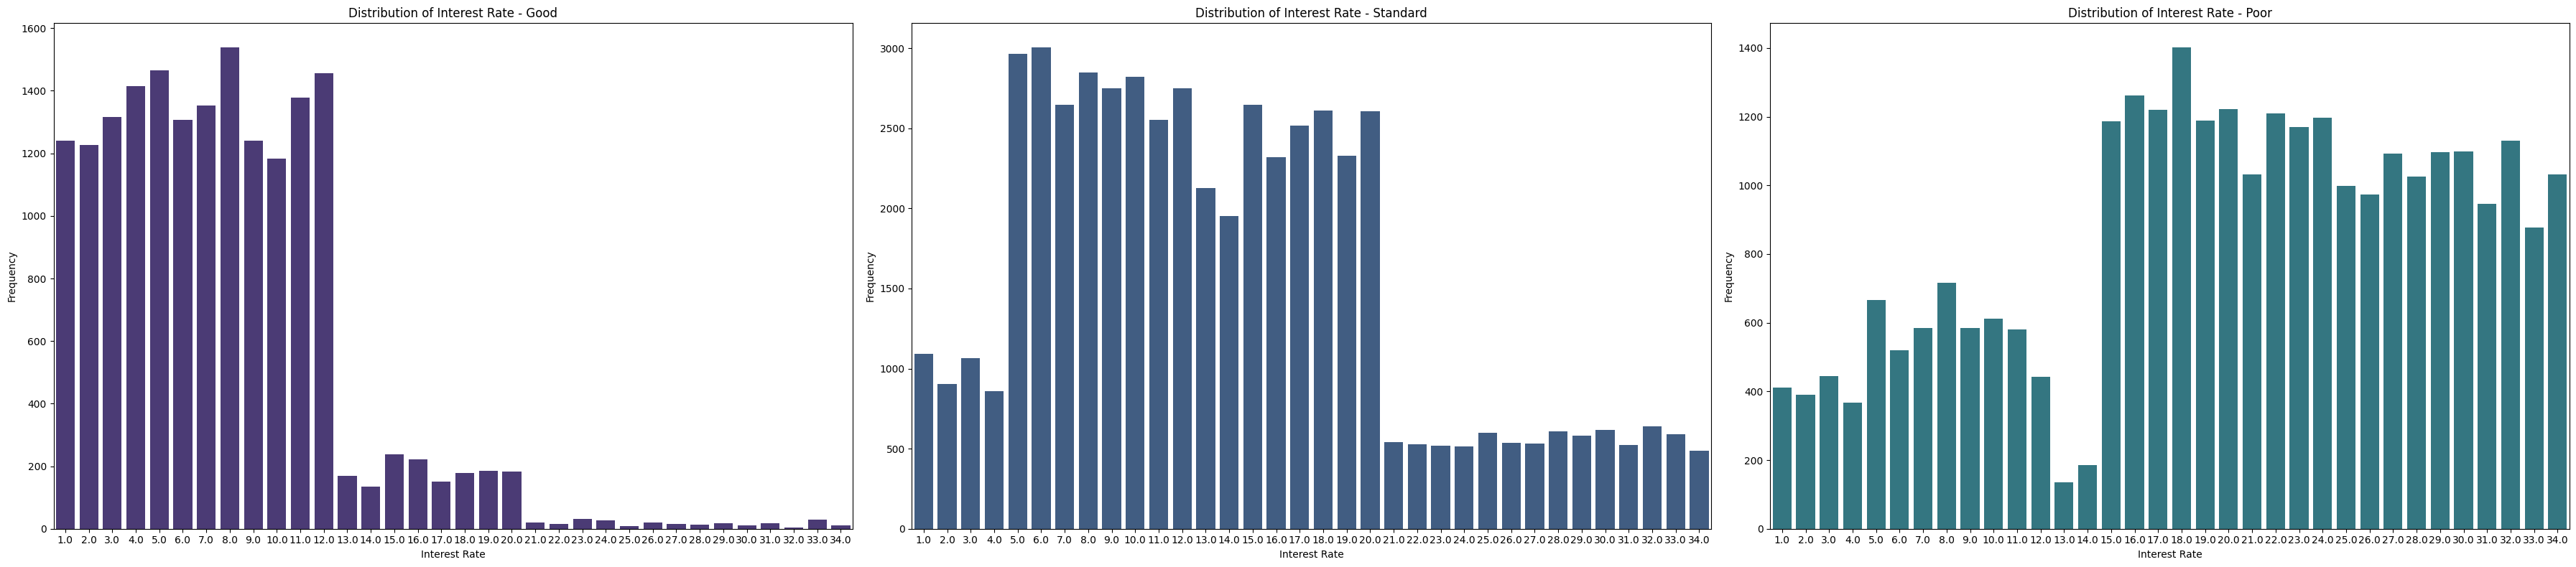

In [ ]:
plt.figure(figsize=(36, 8))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Interest_Rate'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Interest_Rate'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Interest Rate - {category}')
    plt.xlabel('Interest Rate')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Loans by Credit Score Category

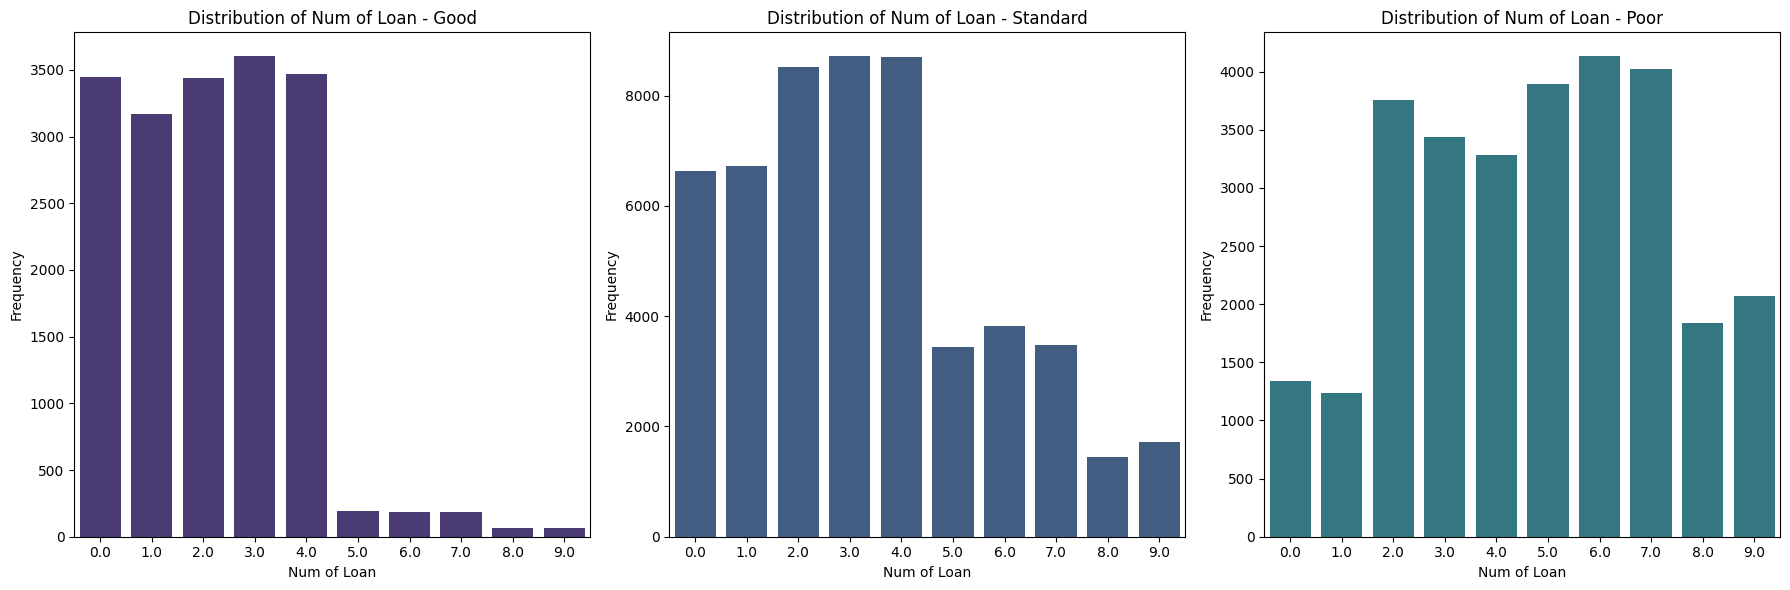

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_of_Loan'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_of_Loan'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Loan - {category}')
    plt.xlabel('Num of Loan')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Delay from due date by Credit Score Category

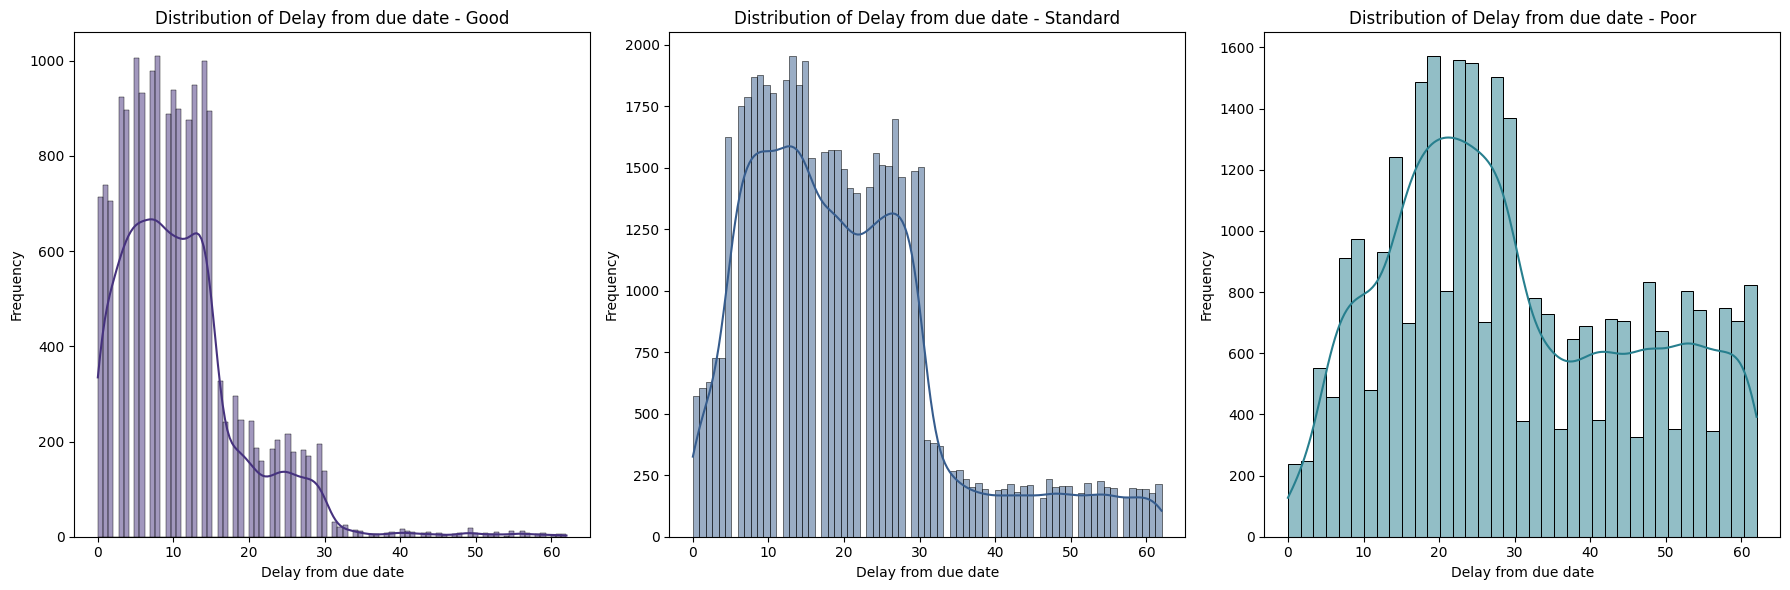

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Delay_from_due_date'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Delay from due date - {category}')
    plt.xlabel('Delay from due date')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Delayed Payment by Credit Score Category

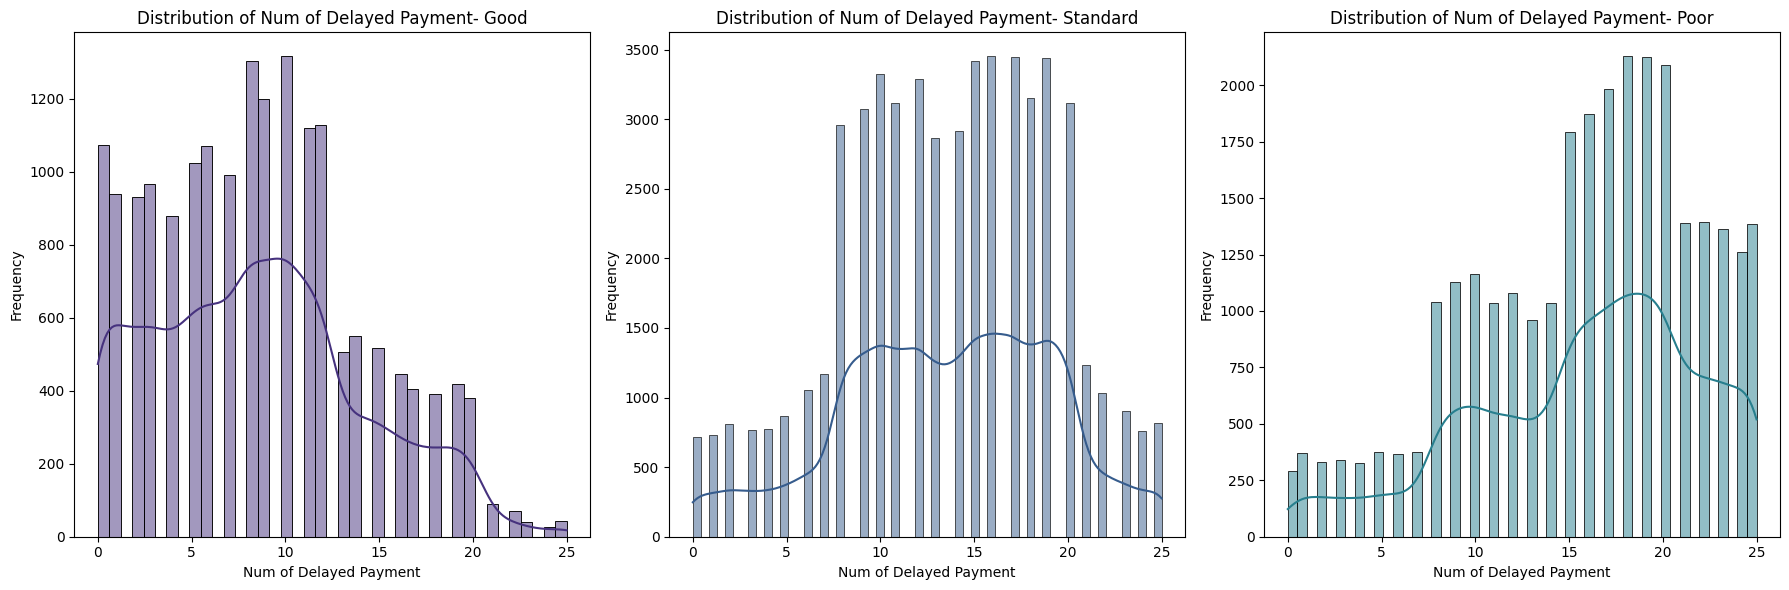

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Num_of_Delayed_Payment'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Delayed Payment- {category}')
    plt.xlabel('Num of Delayed Payment')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Credit Inquiries by Credit Score Category

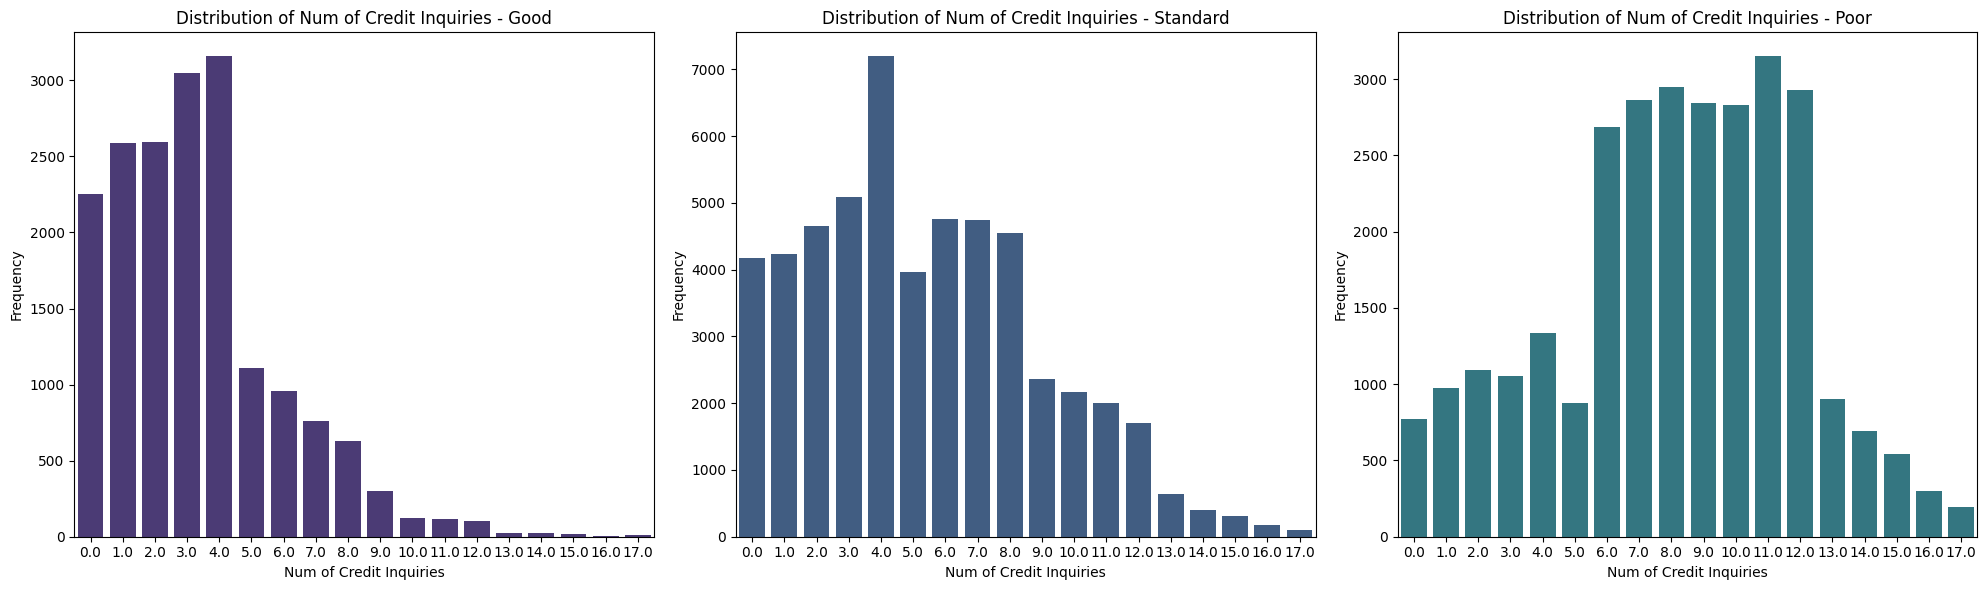

In [ ]:
plt.figure(figsize=(20, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=data[data['Credit_Score'] == category]['Num_Credit_Inquiries'].value_counts().index,
                y=data[data['Credit_Score'] == category]['Num_Credit_Inquiries'].value_counts().values,
                color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Credit Inquiries - {category}')
    plt.xlabel('Num of Credit Inquiries')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Num of Outstanding Debt by Credit Score Category

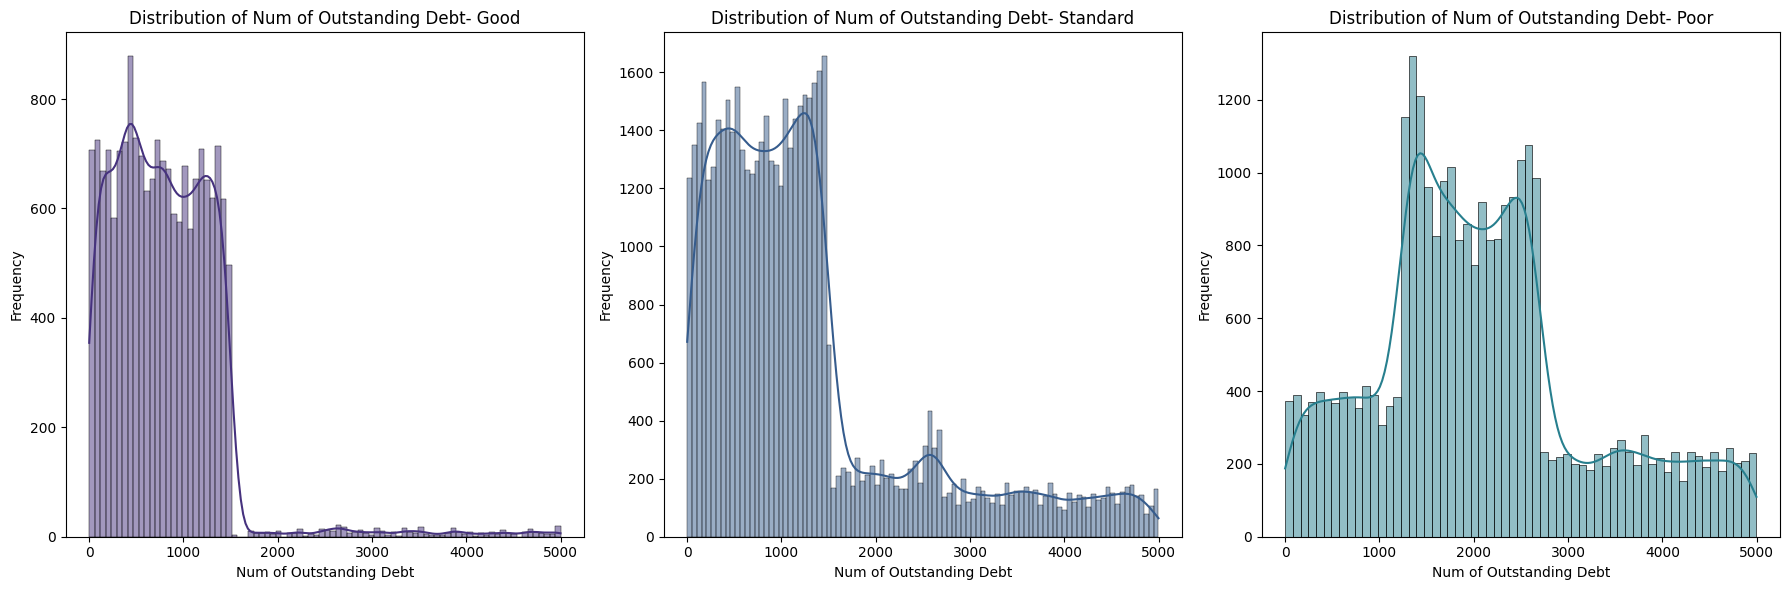

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Outstanding_Debt'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Num of Outstanding Debt- {category}')
    plt.xlabel('Num of Outstanding Debt')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Credit History Age by Credit Score Category

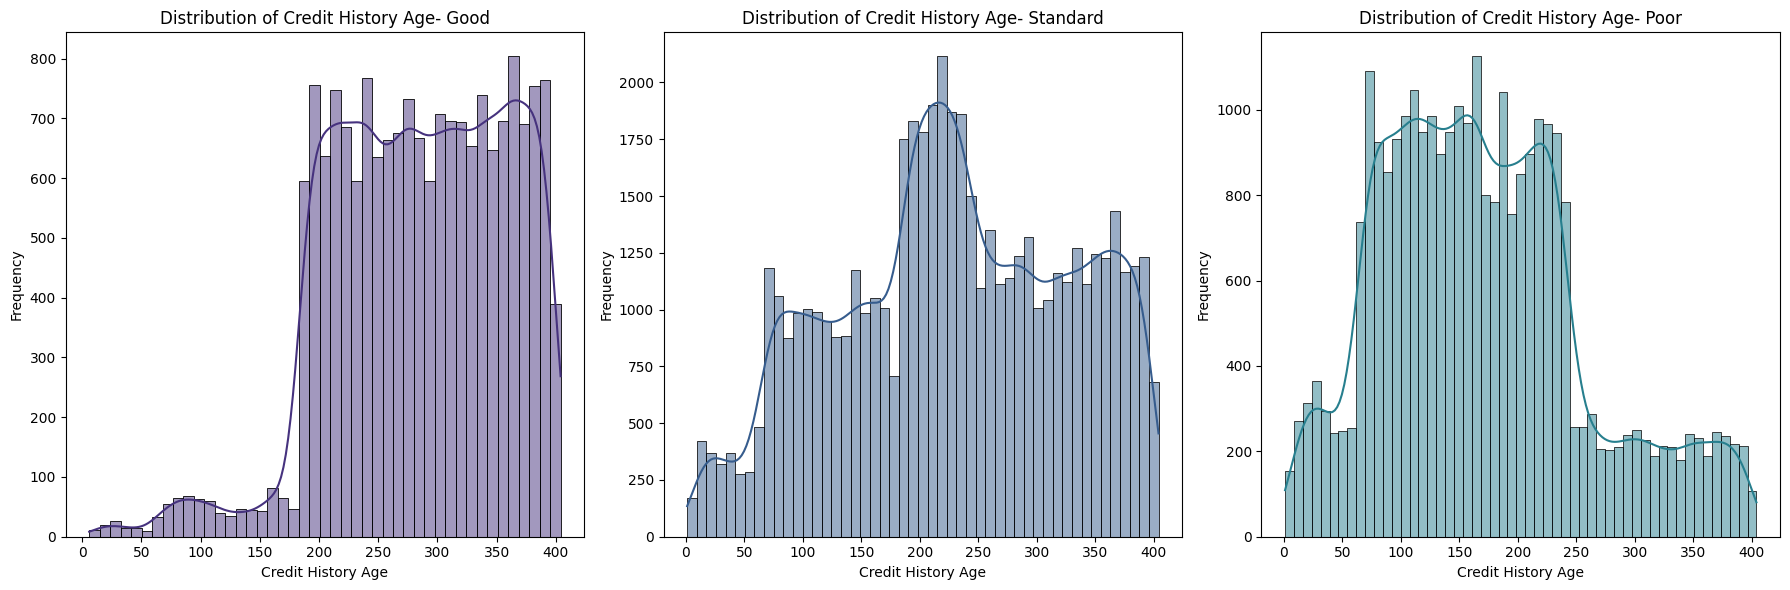

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Credit_History_Age'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Credit History Age- {category}')
    plt.xlabel('Credit History Age')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Total EMI per month by Credit Score Category

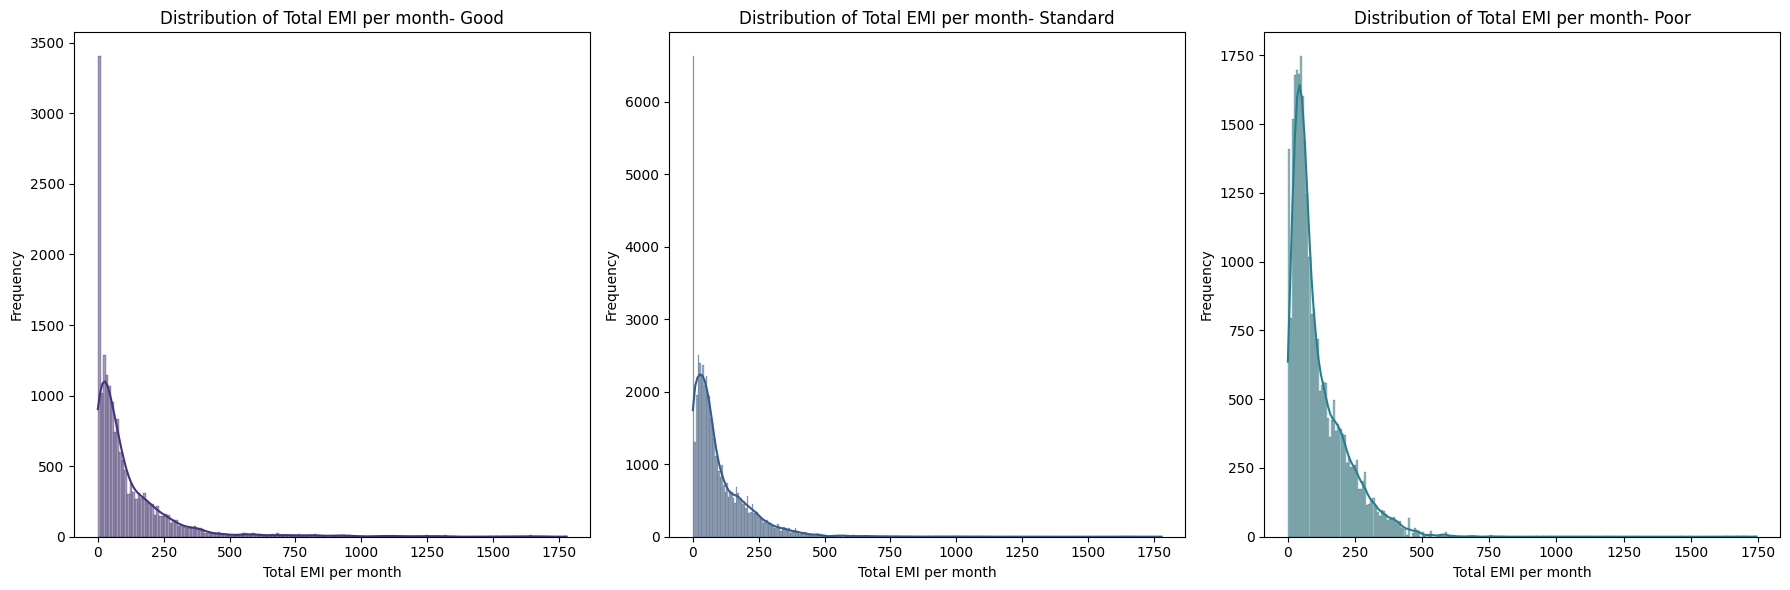

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Total_EMI_per_month'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Total EMI per month- {category}')
    plt.xlabel('Total EMI per month')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Amount invested monthly by Credit Score Category

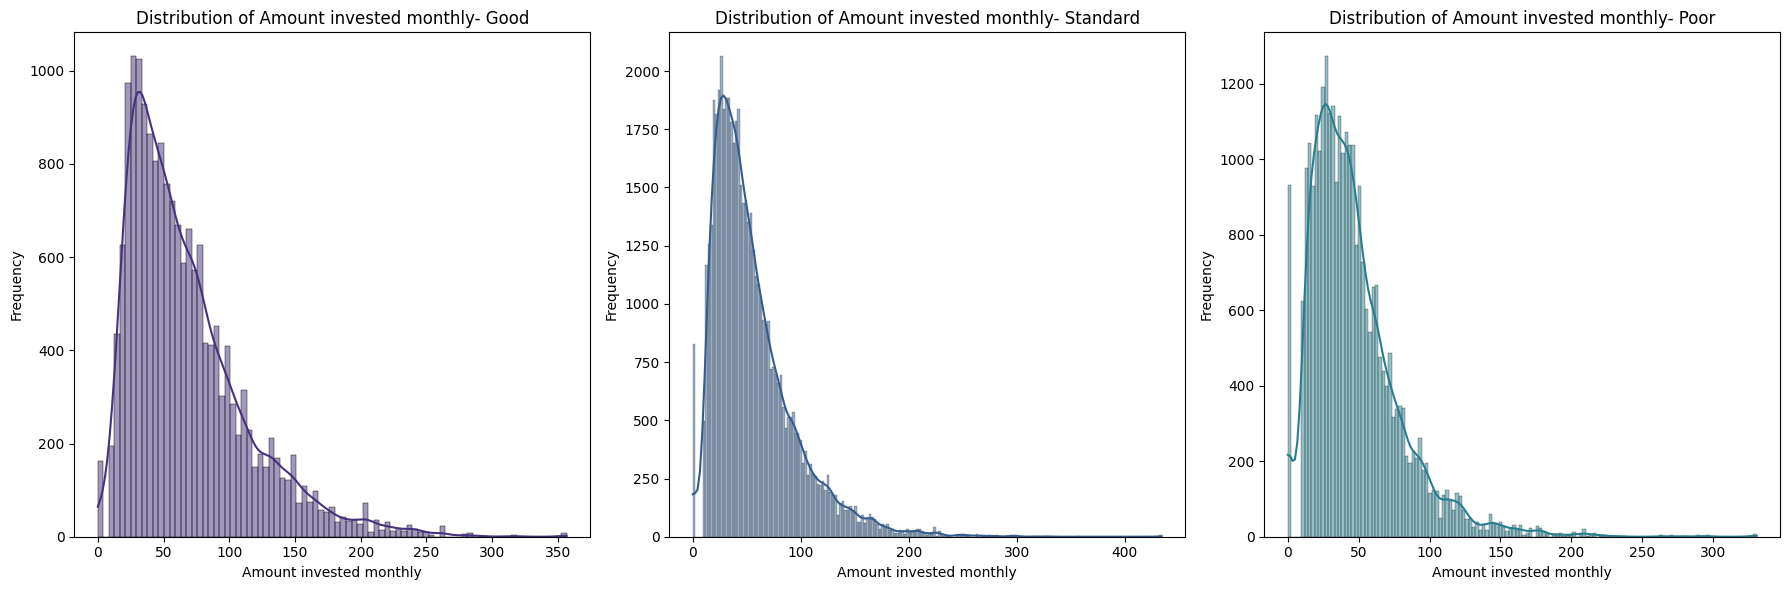

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Amount_invested_monthly'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Amount invested monthly- {category}')
    plt.xlabel('Amount invested monthly')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Monthly Balance by Credit Score Category

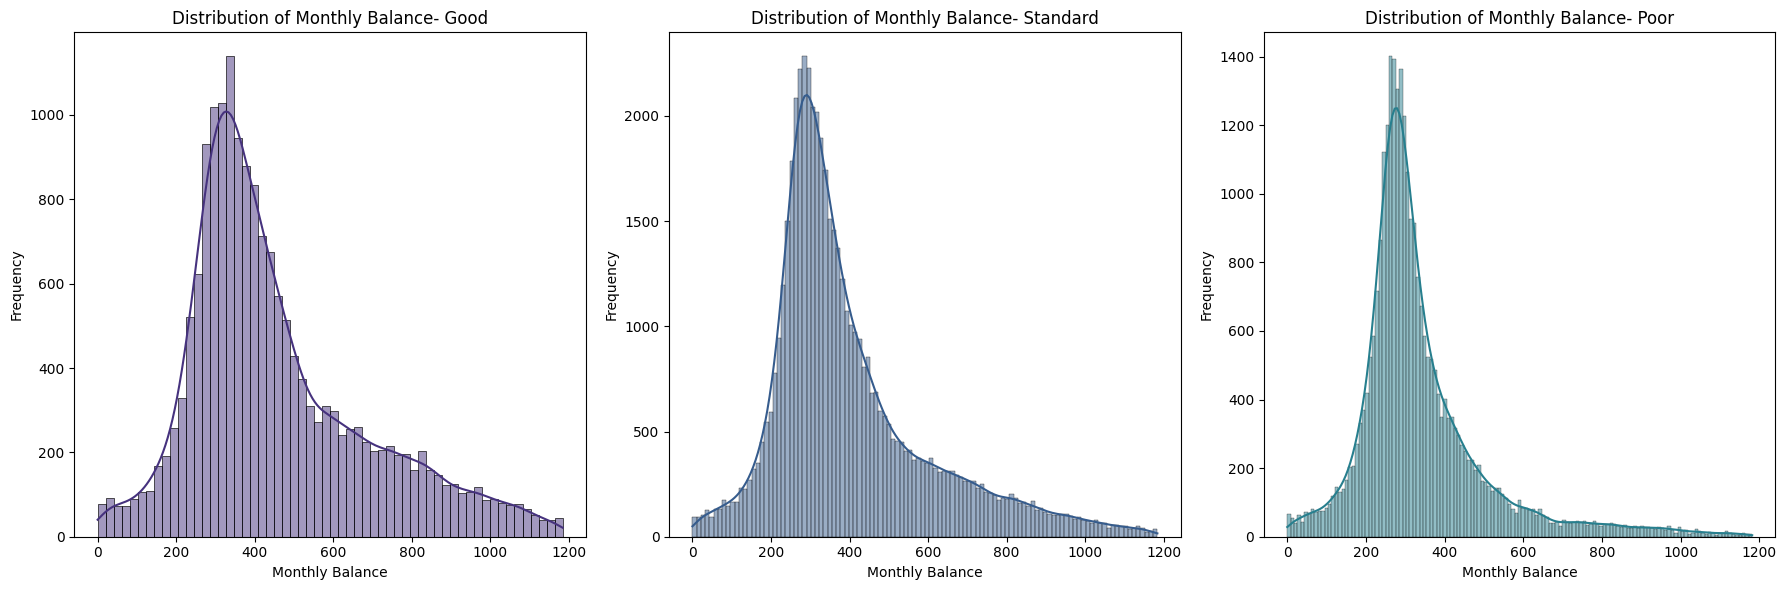

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Monthly_Balance'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Monthly Balance- {category}')
    plt.xlabel('Monthly Balance')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Distribution of Payment Behaviour by Credit Score Category

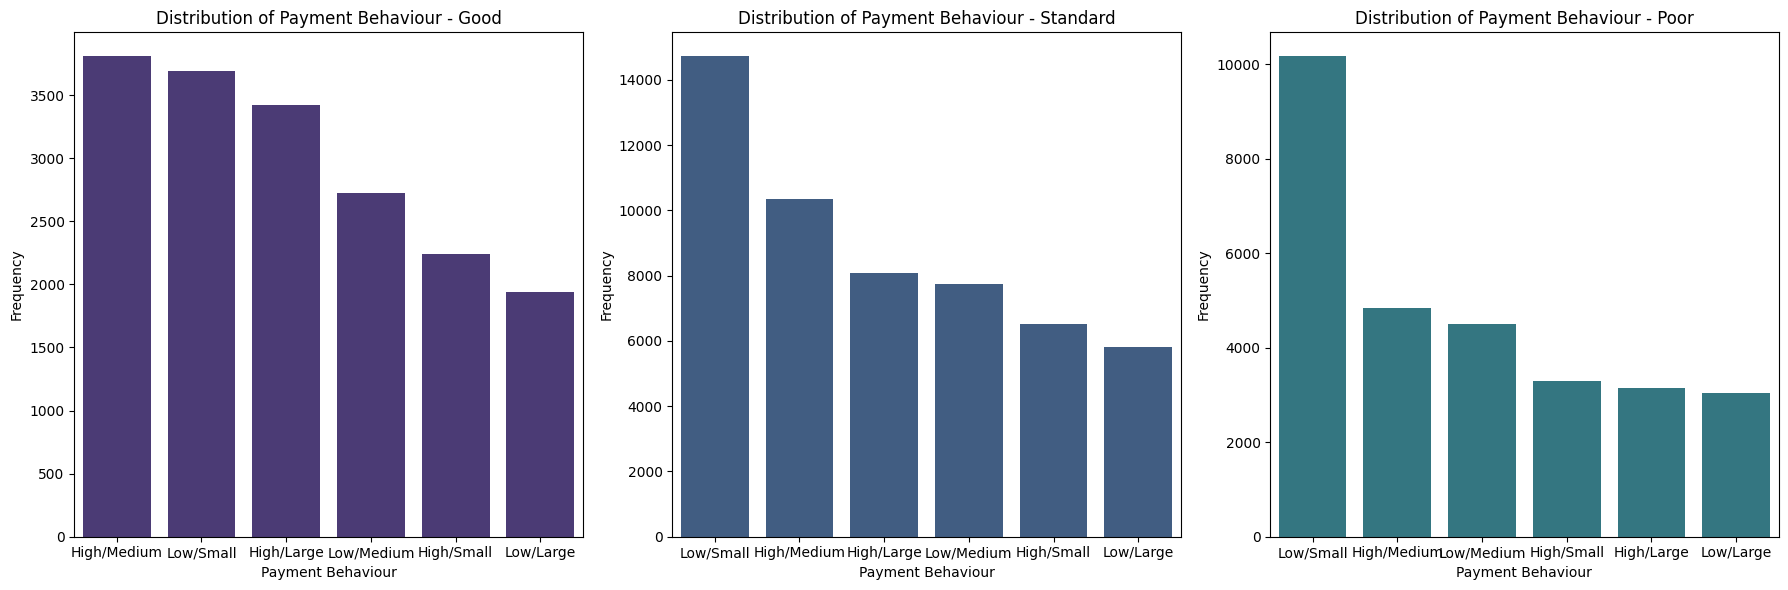

In [ ]:
payment_behaviour_mapping = {
    'Low_spent_Small_value_payments': 'Low/Small',
    'High_spent_Medium_value_payments': 'High/Medium',
    'Low_spent_Medium_value_payments': 'Low/Medium',
    'High_spent_Large_value_payments': 'High/Large',
    'High_spent_Small_value_payments': 'High/Small',
    'Low_spent_Large_value_payments': 'Low/Large'
}

data['Payment_Behaviour'] = data['Payment_Behaviour'].replace(payment_behaviour_mapping)

plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.barplot(
        x=data[data['Credit_Score'] == category]['Payment_Behaviour'].value_counts().index,
        y=data[data['Credit_Score'] == category]['Payment_Behaviour'].value_counts().values,
        color=sns.color_palette("viridis")[i]
    )
    plt.title(f'Distribution of Payment Behaviour - {category}')
    plt.xlabel('Payment Behaviour')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Engineering

## Create a new feature Age_Income_Interaction to understand the interaction between Age and Income


In [ ]:
data['Age_Income_Interaction'] = data['Age'] * data['Annual_Income']

## Create new features Debt_Income_Ratio and Credit_Utilization_per_Card


In [ ]:
data['Debt_Income_Ratio'] = data['Outstanding_Debt'] / data['Annual_Income']
data['Credit_Utilization_per_Card'] = np.where(
    data['Num_Credit_Card'] == 0,
    0,
    data['Credit_Utilization_Ratio'] / data['Num_Credit_Card']
)

In [ ]:
data.sample(10)

ID  Customer_ID  Month             Name   Age          SSN  \
6944    16050         6115      1           Jasonb  30.0  838113561.0   
83434  130784        12510      3  Karen Freifeldq  21.0  864802838.0   
57451   91809        37156      4    James Tophamk  23.0  723632577.0   
14436   27286        44981      5   Jennifer Sabae  17.0  902214884.0   
87173  136391        31021      6    Nate Raymondr  41.0  257238497.0   
62024   98670        25961      1            Marij  19.0   38661703.0   
60585   96511        25087      2           Davidi  34.0  771131222.0   
8177    17899        36228      2         Antidzem  26.0   72519357.0   
31825   53371        14816      2           Jonest  51.0  512166054.0   
77121  121315         2489      2           Alycep  44.0  998304976.0   

          Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
6944   Media_Manager       16579.30            1239.608333               10.0   
83434         Writer       15475.27            1264.605833                6.0   
57451   Entrepreneur       52561.62            4572.135000                7.0   
14436     Journalist       50104.05            4323.337500                4.0   
87173      Architect      147583.40           12224.616667                6.0   
62024       Engineer      121698.48            9892.540000                3.0   
60585        Manager      145932.04           11979.003333                4.0   
8177       Developer        8879.57             557.964167                9.0   
31825      Architect       80393.48            6408.230484                3.0   
77121       Mechanic       58468.08            4592.340000               10.0   

       ...  Credit_History_Age  Payment_of_Min_Amount  Total_EMI_per_month  \
6944   ...               101.0                    Yes            60.486651   
83434  ...               166.0                    Yes            42.087974   
57451  ...               184.0                    Yes            48.935272   
14436  ...               231.0                    Yes            55.009959   
87173  ...               290.0                    Yes             0.000000   
62024  ...                91.0                    Yes           559.516909   
60585  ...               238.0                     No           275.961145   
8177   ...                75.0                    Yes            27.980835   
31825  ...               384.0                     NM           187.664556   
77121  ...                90.0                    Yes           169.465156   

      Amount_invested_monthly  Payment_Behaviour  Monthly_Balance  \
6944                27.013791         Low/Medium       217.338802   
83434               37.289407         Low/Medium       235.511493   
57451               48.705828         High/Large       599.572400   
14436               51.186224         High/Small       452.942835   
87173              113.056354        High/Medium      1108.136199   
62024               74.416501        High/Medium       513.845241   
60585              100.270813         High/Large      1051.718122   
8177                11.914627         High/Small       264.412360   
31825               45.737497         High/Large       568.329656   
77121               38.241835         Low/Medium       388.773981   

       Credit_Score  Age_Income_Interaction Debt_Income_Ratio  \
6944           Poor               497379.00          0.107987   
83434      Standard               324980.67          0.302659   
57451          Poor              1208917.26          0.024967   
14436          Poor               851768.85          0.032690   
87173      Standard              6050919.40          0.001317   
62024      Standard              2312271.12          0.009892   
60585      Standard              4961689.36          0.009467   
8177           Poor               230868.82          0.273041   
31825          Poor              4100067.48          0.004102   
77121          Poor              2572595.52   

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           100000 non-null  int64  
 1   Customer_ID                  100000 non-null  int64  
 2   Month                        100000 non-null  int64  
 3   Name                         100000 non-null  object 
 4   Age                          100000 non-null  float64
 5   SSN                          100000 non-null  float64
 6   Occupation                   100000 non-null  object 
 7   Annual_Income                100000 non-null  float64
 8   Monthly_Inhand_Salary        100000 non-null  float64
 9   Num_Bank_Accounts            100000 non-null  float64
 10  Num_Credit_Card              100000 non-null  float64
 11  Interest_Rate                100000 non-null  float64
 12  Num_of_Loan                  100000 non-null  float64
 13  

In [ ]:
data.describe()

ID    Customer_ID          Month            Age  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    80631.500000   25982.666640       4.500000      33.316340   
std     43301.486619   14340.543051       2.291299      10.764812   
min      5634.000000    1006.000000       1.000000      14.000000   
25%     43132.750000   13664.500000       2.750000      24.000000   
50%     80631.500000   25777.000000       4.500000      33.000000   
75%    118130.250000   38385.000000       6.250000      42.000000   
max    155629.000000   50999.000000       8.000000      56.000000   

                SSN  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
count  1.000000e+05  100000.000000          100000.000000      100000.000000   
mean   5.004617e+08   50505.123449            4197.270835           5.368820   
std    2.908267e+08   38299.422093            3186.432497           2.593314   
min    8.134900e+04    7005.930000             303.645417           0.000000   
25%    2.451686e+08   19342.972500            1626.594167           3.000000   
50%    5.006886e+08   36999.705000            3095.905000           5.000000   
75%    7.560027e+08   71683.470000            5957.715000           7.000000   
max    9.999934e+08  179987.280000           15204.633333          11.000000   

       Num_Credit_Card  Interest_Rate  ...  Num_Credit_Inquiries  \
count    100000.000000   100000.00000  ...         100000.000000   
mean          5.533570       14.53208  ...              5.798250   
std           2.067098        8.74133  ...              3.867826   
min           0.000000        1.00000  ...              0.000000   
25%           4.000000        7.00000  ...              3.000000   
50%           5.000000       13.00000  ...              5.000000   
75%           7.000000       20.00000  ...              8.000000   
max          11.000000       34.00000  ...             17.000000   

       Outstanding_Debt  Credit_Utilization_Ratio  Credit_History_Age  \
count     100000.000000             100000.000000       100000.000000   
mean        1426.220376                 32.285173          221.220460   
std         1155.129026                  5.116875           99.680716   
min            0.230000                 20.000000            1.000000   
25%          566.072500                 28.052567          144.000000   
50%         1166.155000                 32.305784          219.000000   
75%         1945.962500                 36.496663          302.000000   
max         4998.070000                 50.000000          404.000000   

       Total_EMI_per_month  Amount_invested_monthly  Monthly_Balance  \
count        100000.000000            100000.000000    100000.000000   
mean            107.699208                55.101315       392.697586   
std             132.267056                39.006932       201.652719   
min               0.000000                 0.000000         0.007760   
25%              29.268886                27.959111       267.615983   
50%              66.462304                45.156550       333.865366   
75%             147.392573                71.295797       463.215683   
max            1779.103254               434.191089      1183.930696   

       Age_Income_Interaction  Debt_Income_Ratio  Credit_Utilization_per_Card  
count            1.000000e+05      100000.000000                100000.000000  
mean             1.720380e+06           0.060657                     7.162955  
std              1.531718e+06           0.087425                     4.899933  
min              9.808302e+04           0.000003                     0.000000  
25%              6.192719e+05           0.009572                     4.515798  
50%              1.201393e+06           0.028250                     5.914898  
75%              2.319293e+06           0.069716                     8.155190  
max              1.001246e+07           0.683252                    49.522324  

[8 rows x 24 columns]

In [ ]:
data.nunique()

ID                             100000
Customer_ID                     12500
Month                               8
Name                            10128
Age                                43
SSN                             12500
Occupation                         15
Annual_Income                   12488
Monthly_Inhand_Salary           13241
Num_Bank_Accounts                  12
Num_Credit_Card                    12
Interest_Rate                      34
Num_of_Loan                        10
Type_of_Loan                     6261
Delay_from_due_date                63
Num_of_Delayed_Payment             26
Changed_Credit_Limit             3452
Num_Credit_Inquiries               18
Credit_Mix                          3
Outstanding_Debt                12203
Credit_Utilization_Ratio       100000
Credit_History_Age                404
Payment_of_Min_Amount               3
Total_EMI_per_month             11890
Amount_invested_monthly         12261
Payment_Behaviour                   6
Monthly_Bala

## Check the distriution of new columns

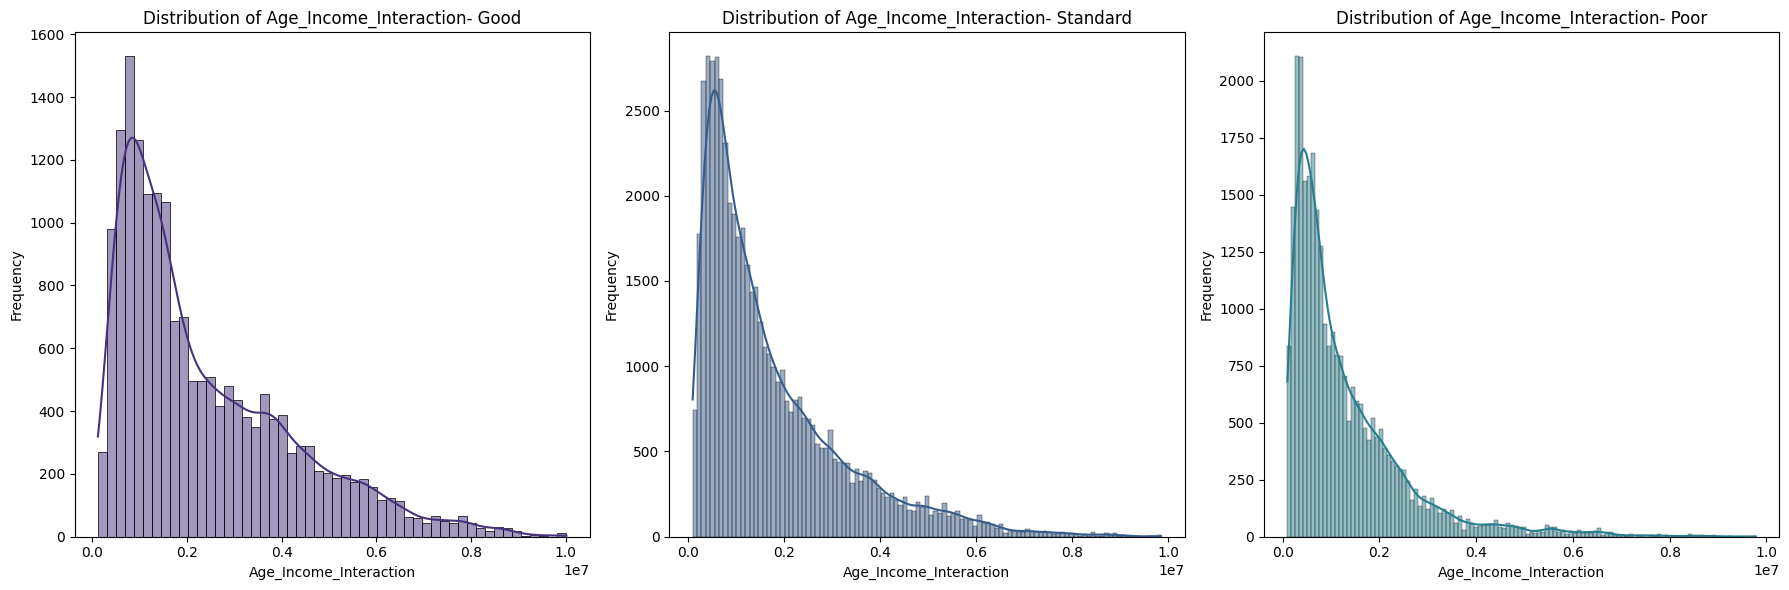

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Age_Income_Interaction'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Age_Income_Interaction- {category}')
    plt.xlabel('Age_Income_Interaction')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

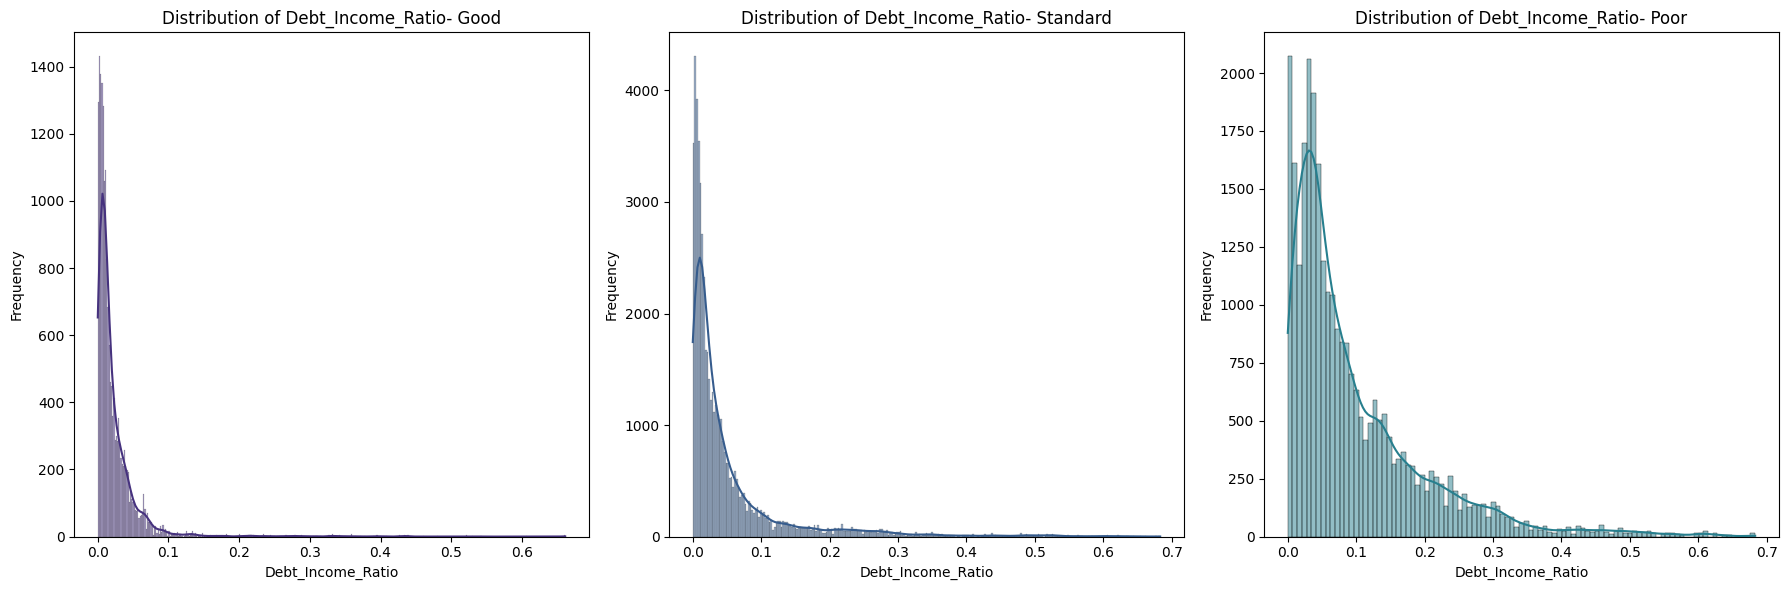

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Debt_Income_Ratio'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Debt_Income_Ratio- {category}')
    plt.xlabel('Debt_Income_Ratio')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

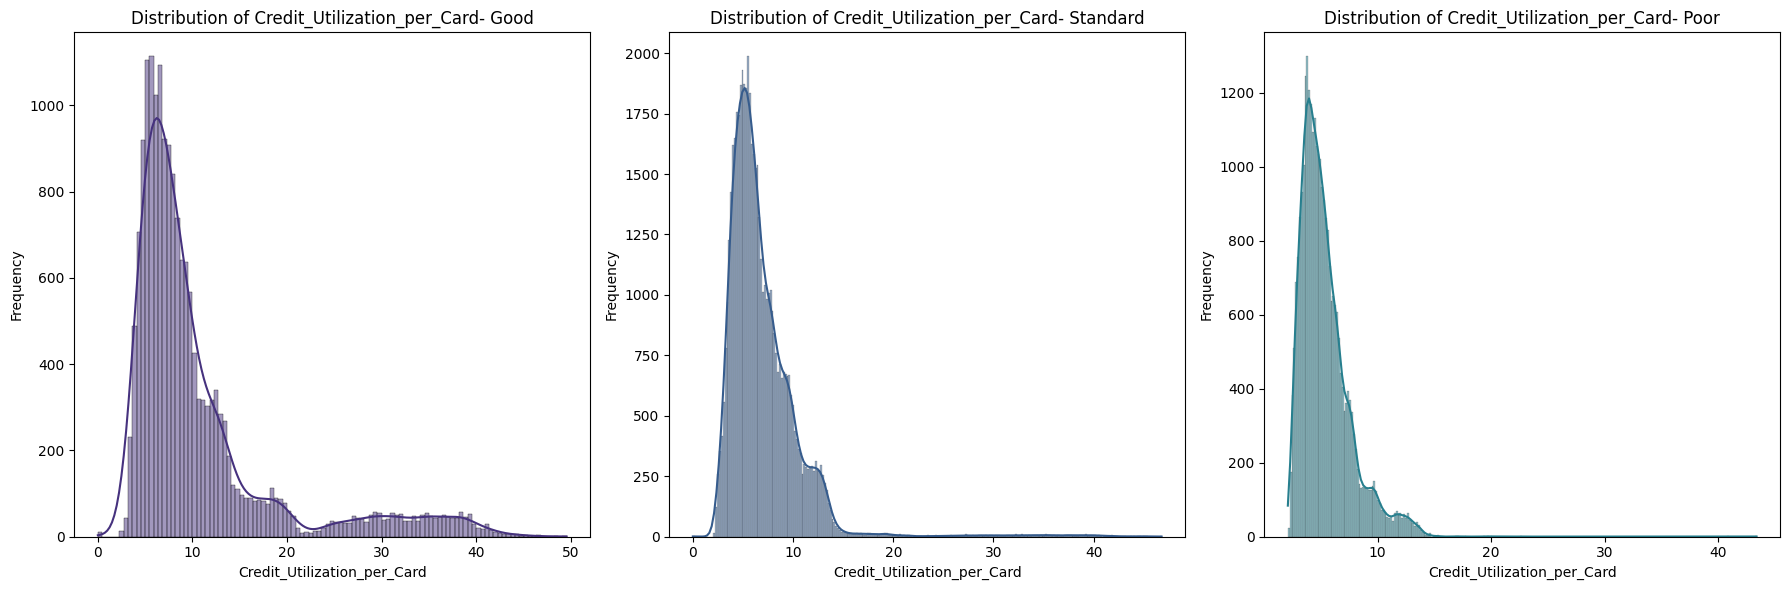

In [ ]:
plt.figure(figsize=(18, 6))

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    sns.histplot(data[data['Credit_Score'] == category]['Credit_Utilization_per_Card'], kde=True, color=sns.color_palette("viridis")[i])
    plt.title(f'Distribution of Credit_Utilization_per_Card- {category}')
    plt.xlabel('Credit_Utilization_per_Card')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Drop unnecessary columns

In [ ]:
data.drop(['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Type_of_Loan', 'Changed_Credit_Limit',
           'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Monthly_Balance'], axis=1, inplace=True)

In [ ]:
data.sample(10)

Age  Occupation  Annual_Income  Monthly_Inhand_Salary  \
62870  35.0     Teacher      16227.030            1646.252500   
55278  27.0    Mechanic      40636.560            3460.380000   
72537  48.0    Mechanic      97838.310            8150.192500   
40893  31.0    Mechanic      36210.300            3029.525000   
46913  38.0    Musician      20547.590            1372.902589   
8890   43.0   Architect      15952.790            1255.399167   
43252  25.0     Teacher      17510.655            1214.221250   
56896  26.0  Journalist      22015.680            2037.640000   
23412  48.0    Musician      33388.100            2599.341667   
11208  27.0   Developer     133949.360           11262.446667   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
62870                6.0              8.0           21.0          5.0   
55278                2.0              6.0            1.0          1.0   
72537                0.0              3.0            4.0          1.0   
40893                9.0              8.0           30.0          4.0   
46913                6.0              4.0           13.0          1.0   
8890                 5.0              1.0            3.0          3.0   
43252                5.0              7.0           19.0          0.0   
56896                6.0              5.0            7.0          5.0   
23412                6.0              4.0            8.0          0.0   
11208                5.0              5.0            8.0          0.0   

       Delay_from_due_date  Num_of_Delayed_Payment  ...  Credit_Mix  \
62870                 18.0                    12.0  ...    Standard   
55278                 15.0                     7.0  ...        Good   
72537                 10.0                     7.0  ...        Good   
40893                 53.0                    18.0  ...         Bad   
46913                 20.0                    19.0  ...    Standard   
8890                  13.0                     9.0  ...        Good   
43252                 18.0                    12.0  ...    Standard   
56896                 27.0                    12.0  ...    Standard   
23412                 19.0                    16.0  ...    Standard   
11208                  0.0                     2.0  ...        Good   

      Outstanding_Debt  Credit_History_Age  Payment_of_Min_Amount  \
62870          1541.87               185.0                    Yes   
55278           490.98               340.0                     No   
72537            56.47               186.0                     No   
40893          1744.57               230.0                    Yes   
46913           942.99               207.0                    Yes   
8890            645.40               187.0                     No   
43252          1215.11               270.0                     No   
56896           775.52               147.0                    Yes   
23412           589.89               242.0                    Yes   
11208          1454.68               215.0                     No   

      Total_EMI_per_month  Payment_Behaviour Credit_Score  \
62870           49.997642          Low/Small         Poor   
55278           31.226807          Low/Large     Standard   
72537           74.847495          Low/Small         Good   
40893          106.039477          Low/Small         Poor   
46913          120.245843        High/Medium     Standard   
8890            25.384485         Low/Medium         Good   
43252            0.000000          Low/Small     Standard   
56896           74.741710          Low/Large     Standard   
23412            0.000000          Low/Small     Standard   
11208            0.000000          Low/Small         Good   

      Age_Income_Interaction  Debt_Income_Ratio  Credit_Utilization_per_Card  
62870             567946.050           0.095019                     3.801809  
55278            1097187.120           0.012082                     6.341641  
72537            4696238.880         

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Annual_Income                100000 non-null  float64
 3   Monthly_Inhand_Salary        100000 non-null  float64
 4   Num_Bank_Accounts            100000 non-null  float64
 5   Num_Credit_Card              100000 non-null  float64
 6   Interest_Rate                100000 non-null  float64
 7   Num_of_Loan                  100000 non-null  float64
 8   Delay_from_due_date          100000 non-null  float64
 9   Num_of_Delayed_Payment       100000 non-null  float64
 10  Num_Credit_Inquiries         100000 non-null  float64
 11  Credit_Mix                   100000 non-null  object 
 12  Outstanding_Debt             100000 non-null  float64
 13  

# Association

In [ ]:
num_cols = data.select_dtypes(include=['float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Numerical Columns: ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_History_Age', 'Total_EMI_per_month', 'Age_Income_Interaction', 'Debt_Income_Ratio', 'Credit_Utilization_per_Card']
Categorical Columns: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']


## Cramer's V

In [ ]:
crv = data.apply(lambda x: x.astype("category") if x.dtype == "O" or x.dtype == "bool" else x)
cramers_v = am.CramersV(crv)

cfit = cramers_v.fit().round(2)
cfit

Occupation  Credit_Mix  Payment_of_Min_Amount  \
Occupation                   1.00        0.03                   0.02   
Credit_Mix                   0.03        1.00                   0.54   
Payment_of_Min_Amount        0.02        0.54                   1.00   
Payment_Behaviour            0.01        0.09                   0.08   
Credit_Score                 0.03        0.45                   0.31   

                       Payment_Behaviour  Credit_Score  
Occupation                          0.01          0.03  
Credit_Mix                          0.09          0.45  
Payment_of_Min_Amount               0.08          0.31  
Payment_Behaviour                   1.00          0.09  
Credit_Score                        0.09          1.00

**Payment_Behaviour** and **Occupation** have very less association with **Credit_Score**.

## Correlation Matrix

In [ ]:
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2}))

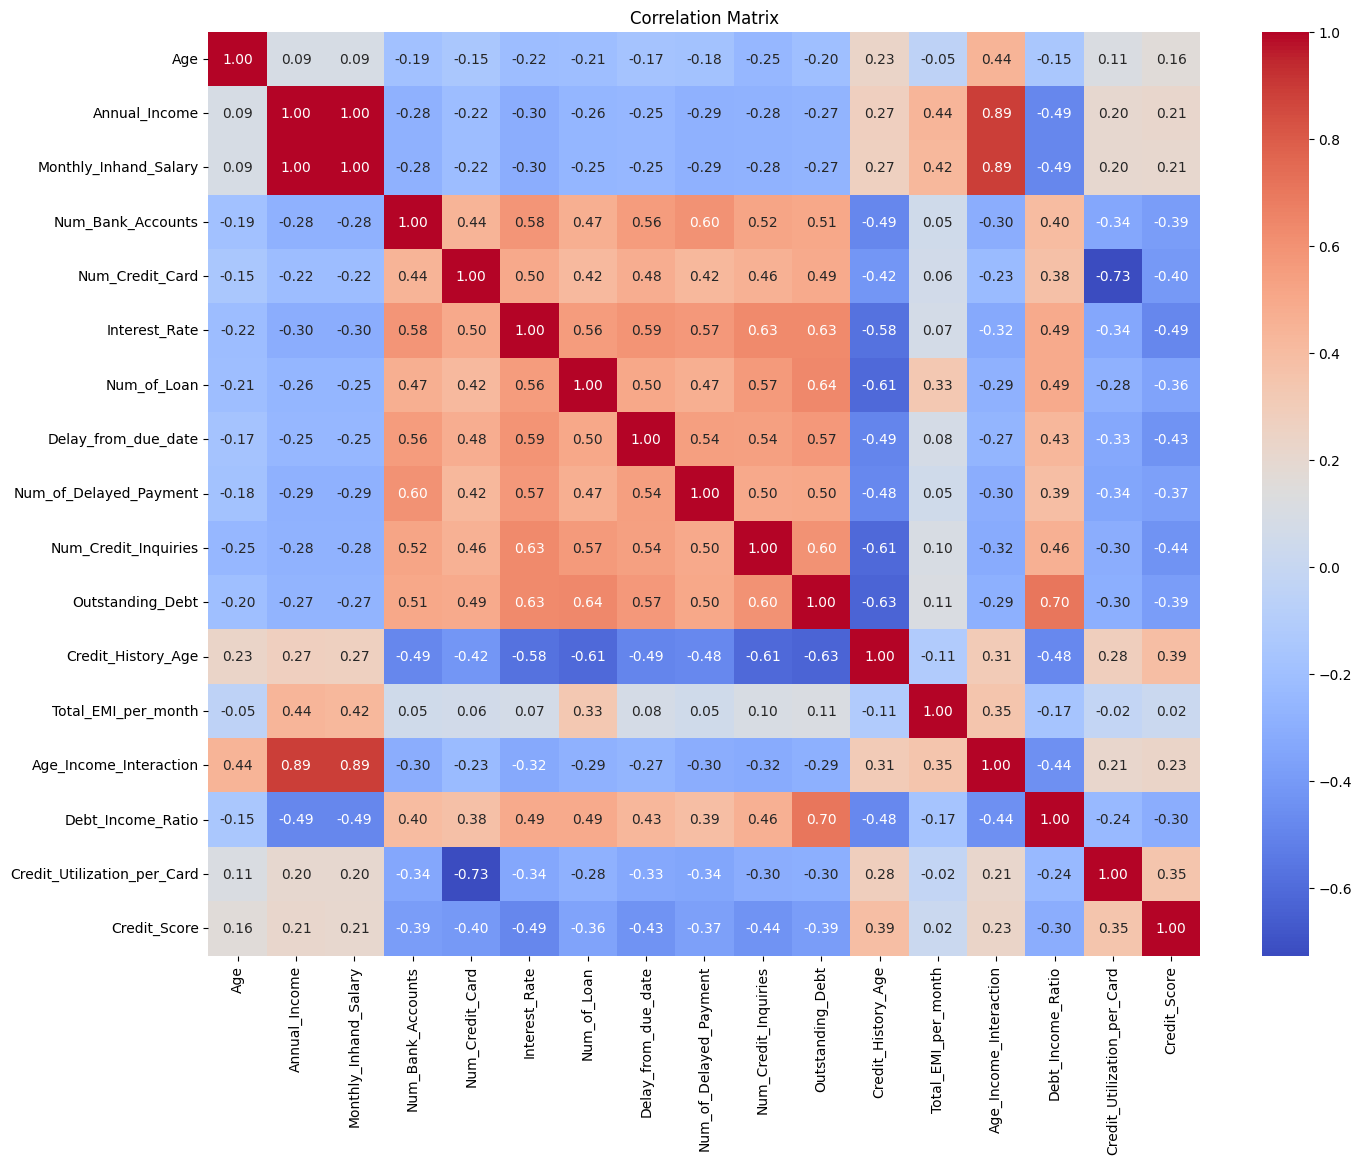

In [ ]:
corr_matrix = data[num_cols + ['Credit_Score']].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

**High Multicollinearity between some features.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Annual_Income                100000 non-null  float64
 3   Monthly_Inhand_Salary        100000 non-null  float64
 4   Num_Bank_Accounts            100000 non-null  float64
 5   Num_Credit_Card              100000 non-null  float64
 6   Interest_Rate                100000 non-null  float64
 7   Num_of_Loan                  100000 non-null  float64
 8   Delay_from_due_date          100000 non-null  float64
 9   Num_of_Delayed_Payment       100000 non-null  float64
 10  Num_Credit_Inquiries         100000 non-null  float64
 11  Credit_Mix                   100000 non-null  object 
 12  Outstanding_Debt             100000 non-null  float64
 13  

## Handling Multicollinearity by taking subset of features

In [ ]:
num_cols = data.select_dtypes(include=['float64']).columns.tolist()

X = data.drop(columns=['Credit_Score'])
Y = data['Credit_Score']

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df = calculate_vif(X[num_cols])
vif_df_sorted = vif_df.sort_values(by='VIF', ascending=False)
print(vif_df_sorted)

                        Feature         VIF
1                 Annual_Income  886.937505
2         Monthly_Inhand_Salary  841.121507
13       Age_Income_Interaction   24.723406
0                           Age   21.108019
4               Num_Credit_Card   17.152284
8        Num_of_Delayed_Payment   10.374584
3             Num_Bank_Accounts   10.332463
11           Credit_History_Age    9.725081
5                 Interest_Rate    9.134004
10             Outstanding_Debt    8.508629
6                   Num_of_Loan    7.794483
9          Num_Credit_Inquiries    6.974930
7           Delay_from_due_date    5.993570
15  Credit_Utilization_per_Card    5.098279
14            Debt_Income_Ratio    3.853875
12          Total_EMI_per_month    3.283392


In [ ]:
num_cols = [col for col in num_cols if col not in ['Annual_Income', 'Monthly_Inhand_Salary']]

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif_df_reduced = calculate_vif(X[num_cols])

vif_df_reduced_sorted = vif_df_reduced.sort_values(by='VIF', ascending=False)
print(vif_df_reduced_sorted)

                        Feature        VIF
2               Num_Credit_Card  15.506946
0                           Age  12.531232
6        Num_of_Delayed_Payment  10.317348
1             Num_Bank_Accounts  10.301341
3                 Interest_Rate   9.132118
9            Credit_History_Age   8.588978
8              Outstanding_Debt   8.428893
4                   Num_of_Loan   7.570229
7          Num_Credit_Inquiries   6.954479
5           Delay_from_due_date   5.990285
13  Credit_Utilization_per_Card   4.522251
11       Age_Income_Interaction   4.449548
12            Debt_Income_Ratio   3.699814
10          Total_EMI_per_month   2.786733


In [ ]:
data.drop(['Annual_Income', 'Monthly_Inhand_Salary'], axis=1, inplace=True)

# Split the dataset

In [ ]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

In [ ]:
X.head()

Age Occupation  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  \
0  23.0  Scientist                3.0              4.0            3.0   
1  23.0  Scientist                3.0              4.0            3.0   
2  23.0  Scientist                3.0              4.0            3.0   
3  23.0  Scientist                3.0              4.0            3.0   
4  23.0  Scientist                3.0              4.0            3.0   

   Num_of_Loan  Delay_from_due_date  Num_of_Delayed_Payment  \
0          4.0                  3.0                     7.0   
1          4.0                  3.0                     4.0   
2          4.0                  3.0                     7.0   
3          4.0                  5.0                     4.0   
4          4.0                  6.0                     4.0   

   Num_Credit_Inquiries Credit_Mix  Outstanding_Debt  Credit_History_Age  \
0                   4.0       Good            809.98               265.0   
1                   4.0       Good            809.98               266.0   
2                   4.0       Good            809.98               267.0   
3                   4.0       Good            809.98               268.0   
4                   4.0       Good            809.98               269.0   

  Payment_of_Min_Amount  Total_EMI_per_month Payment_Behaviour  \
0                    No            49.574949        High/Small   
1                    No            49.574949         Low/Large   
2                    No            49.574949        Low/Medium   
3                    No            49.574949         Low/Small   
4                    No            49.574949       High/Medium   

   Age_Income_Interaction  Debt_Income_Ratio  Credit_Utilization_per_Card  
0               439624.76           0.042376                     6.705655  
1               439624.76           0.042376                     7.986240  
2               439624.76           0.042376                     7.152338  
3               439624.76           0.042376                     7.844465  
4               439624.76           0.042376                     6.199337

In [ ]:
y.sample(5)

27790    2
82456    1
15687    2
89218    1
15479    2
Name: Credit_Score, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 18), (30000, 18), (70000,), (30000,))

# Encoding

## Target Encoding (Mean Encoding)

In [ ]:
X_train['Credit_Score'] = y_train

occupation_mean = X_train.groupby('Occupation')['Credit_Score'].mean()
payment_of_min_amount_mean = X_train.groupby('Payment_of_Min_Amount')['Credit_Score'].mean()
payment_behaviour_mean = X_train.groupby('Payment_Behaviour')['Credit_Score'].mean()

X_train['Occupation_encoded'] = X_train['Occupation'].map(occupation_mean)
X_train['Payment_of_Min_Amount_encoded'] = X_train['Payment_of_Min_Amount'].map(payment_of_min_amount_mean)
X_train['Payment_Behaviour_encoded'] = X_train['Payment_Behaviour'].map(payment_behaviour_mean)

X_train.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score'], axis=1, inplace=True)

X_test['Occupation_encoded'] = X_test['Occupation'].map(occupation_mean)
X_test['Payment_of_Min_Amount_encoded'] = X_test['Payment_of_Min_Amount'].map(payment_of_min_amount_mean)
X_test['Payment_Behaviour_encoded'] = X_test['Payment_Behaviour'].map(payment_behaviour_mean)

X_test.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis=1, inplace=True)

## Label Encoding

In [ ]:
credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}

X_train['Credit_Mix'] = X_train['Credit_Mix'].map(credit_mix_map)
X_test['Credit_Mix'] = X_test['Credit_Mix'].map(credit_mix_map)

In [ ]:
X_train.sample(10)

Age  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
97922  44.0                6.0              5.0           24.0          4.0   
46624  44.0                6.0              7.0           15.0          0.0   
50256  41.0                3.0              4.0            5.0          0.0   
99352  44.0                2.0              4.0            9.0          4.0   
30608  14.0                8.0              8.0           18.0          7.0   
82635  34.0                8.0              7.0           34.0          4.0   
13462  20.0                8.0              8.0           26.0          9.0   
52043  18.0                7.0              7.0           11.0          4.0   
98031  44.0                3.0              4.0            6.0          3.0   
60258  53.0                4.0              5.0           12.0          4.0   

       Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
97922                 57.0                    12.0                  15.0   
46624                  5.0                    20.0                   4.0   
50256                 19.0                    14.0                   4.0   
99352                  3.0                     4.0                   4.0   
30608                 17.0                    11.0                   6.0   
82635                 21.0                    25.0                   8.0   
13462                 61.0                    21.0                  13.0   
52043                 18.0                    10.0                   7.0   
98031                 24.0                    13.0                   6.0   
60258                  7.0                    11.0                   1.0   

       Credit_Mix  Outstanding_Debt  Credit_History_Age  Total_EMI_per_month  \
97922           1           2165.25                72.0            21.778278   
46624           1           1375.66               343.0             0.000000   
50256           1            555.42               200.0             0.000000   
99352           2            823.21               382.0            65.051299   
30608           1           1870.54               232.0            80.511853   
82635           0           1968.73                73.0            18.530676   
13462           0           4742.53                16.0           165.891821   
52043           1           1350.40                97.0           197.610910   
98031           2            970.11               393.0           161.034389   
60258           2           1187.52               381.0            61.665344   

       Age_Income_Interaction  Debt_Income_Ratio  Credit_Utilization_per_Card  \
97922               341232.98           0.279196                     5.139463   
46624               714169.06           0.084754                     5.689785   
50256              2234165.44           0.010193                     8.950316   
99352               863775.44           0.041934                     9.007141   
30608               289255.96           0.090534                     3.872817   
82635               337173.41           0.198523                     4.163912   
13462               618450.00           0.153368                     3.932230   
52043              1103068.80           0.022036                     4.452942   
98031              3555524.28           0.012005                     6.981880   
60258              1142351.93           0.055096                     5.585374   

       Occupation_encoded  Payment_of_Min_Amount_encoded  \
97922            0.876378                       0.643626   
46624            0.900111                       1.249870   
50256            0.880529                       0.643626   
99352            0.900111                       1.249870   
30608            0.839517                       0.643626   
82635            0.911063                       0.643626   
13462            0.880529                       0.643626   
52043            0.876378                       

In [ ]:
X_test.sample(10)

Age  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
67669  20.0                5.0              6.0           19.0          3.0   
57459  20.0                7.0             10.0           25.0          7.0   
78829  23.0                9.0              5.0           16.0          6.0   
32025  45.0                6.0              3.0           14.0          4.0   
91127  38.0                1.0              6.0            9.0          3.0   
3752   29.0                9.0              5.0           28.0          8.0   
15774  15.0                6.0             10.0           27.0          4.0   
28153  32.0                6.0              5.0            5.0          7.0   
16393  49.0                1.0              6.0            8.0          1.0   
93737  26.0                8.0              6.0           34.0          8.0   

       Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
67669                 11.0                    10.0                   1.0   
57459                 10.0                    11.0                   7.0   
78829                 21.0                    22.0                  10.0   
32025                 35.0                    12.0                   2.0   
91127                  8.0                     6.0                   2.0   
3752                  60.0                    21.0                   7.0   
15774                 47.0                    22.0                  11.0   
28153                 20.0                    14.0                   7.0   
16393                  9.0                     9.0                   0.0   
93737                 35.0                    24.0                   6.0   

       Credit_Mix  Outstanding_Debt  Credit_History_Age  Total_EMI_per_month  \
67669           1            550.61               392.0           280.979169   
57459           1           2211.70               121.0            38.276519   
78829           0           3013.18               162.0           208.985026   
32025           1           1418.49               284.0            55.007097   
91127           2           1163.93               312.0           343.189354   
3752            0           4270.21                91.0           245.095892   
15774           0           1368.27                76.0            72.421755   
28153           1            289.05               220.0            72.581554   
16393           2            912.94               269.0            11.377456   
93737           0           3938.70                23.0            53.343671   

       Age_Income_Interaction  Debt_Income_Ratio  Credit_Utilization_per_Card  \
67669             2335612.000           0.004715                     6.197632   
57459              159595.500           0.277163                     3.203451   
78829             1123661.550           0.061676                     5.644314   
32025             1014998.400           0.062889                     7.335929   
91127             6434915.440           0.006873                     6.824489   
3752              1604404.410           0.077185                     6.936227   
15774              533897.400           0.038442                     3.738670   
28153              558868.480           0.016551                     4.904081   
16393              783444.585           0.057099                     5.509190   
93737              211578.250           0.484011                     5.781041   

       Occupation_encoded  Payment_of_Min_Amount_encoded  \
67669            0.898243                       0.643626   
57459            0.916760                       0.643626   
78829            0.883330                       0.643626   
32025            0.880161                       1.249870   
91127            0.866411                       1.249870   
3752             0.913125                       0.643626   
15774            0.880161                       0.643626   
28153            0.883330                       

In [ ]:
X_train.isnull().sum()

Age                              0
Num_Bank_Accounts                0
Num_Credit_Card                  0
Interest_Rate                    0
Num_of_Loan                      0
Delay_from_due_date              0
Num_of_Delayed_Payment           0
Num_Credit_Inquiries             0
Credit_Mix                       0
Outstanding_Debt                 0
Credit_History_Age               0
Total_EMI_per_month              0
Age_Income_Interaction           0
Debt_Income_Ratio                0
Credit_Utilization_per_Card      0
Occupation_encoded               0
Payment_of_Min_Amount_encoded    0
Payment_Behaviour_encoded        0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Age                          100000 non-null  float64
 1   Occupation                   100000 non-null  object 
 2   Num_Bank_Accounts            100000 non-null  float64
 3   Num_Credit_Card              100000 non-null  float64
 4   Interest_Rate                100000 non-null  float64
 5   Num_of_Loan                  100000 non-null  float64
 6   Delay_from_due_date          100000 non-null  float64
 7   Num_of_Delayed_Payment       100000 non-null  float64
 8   Num_Credit_Inquiries         100000 non-null  float64
 9   Credit_Mix                   100000 non-null  object 
 10  Outstanding_Debt             100000 non-null  float64
 11  Credit_History_Age           100000 non-null  float64
 12  Payment_of_Min_Amount        100000 non-null  object 
 13  

## Re-checking the Correlation Matrix

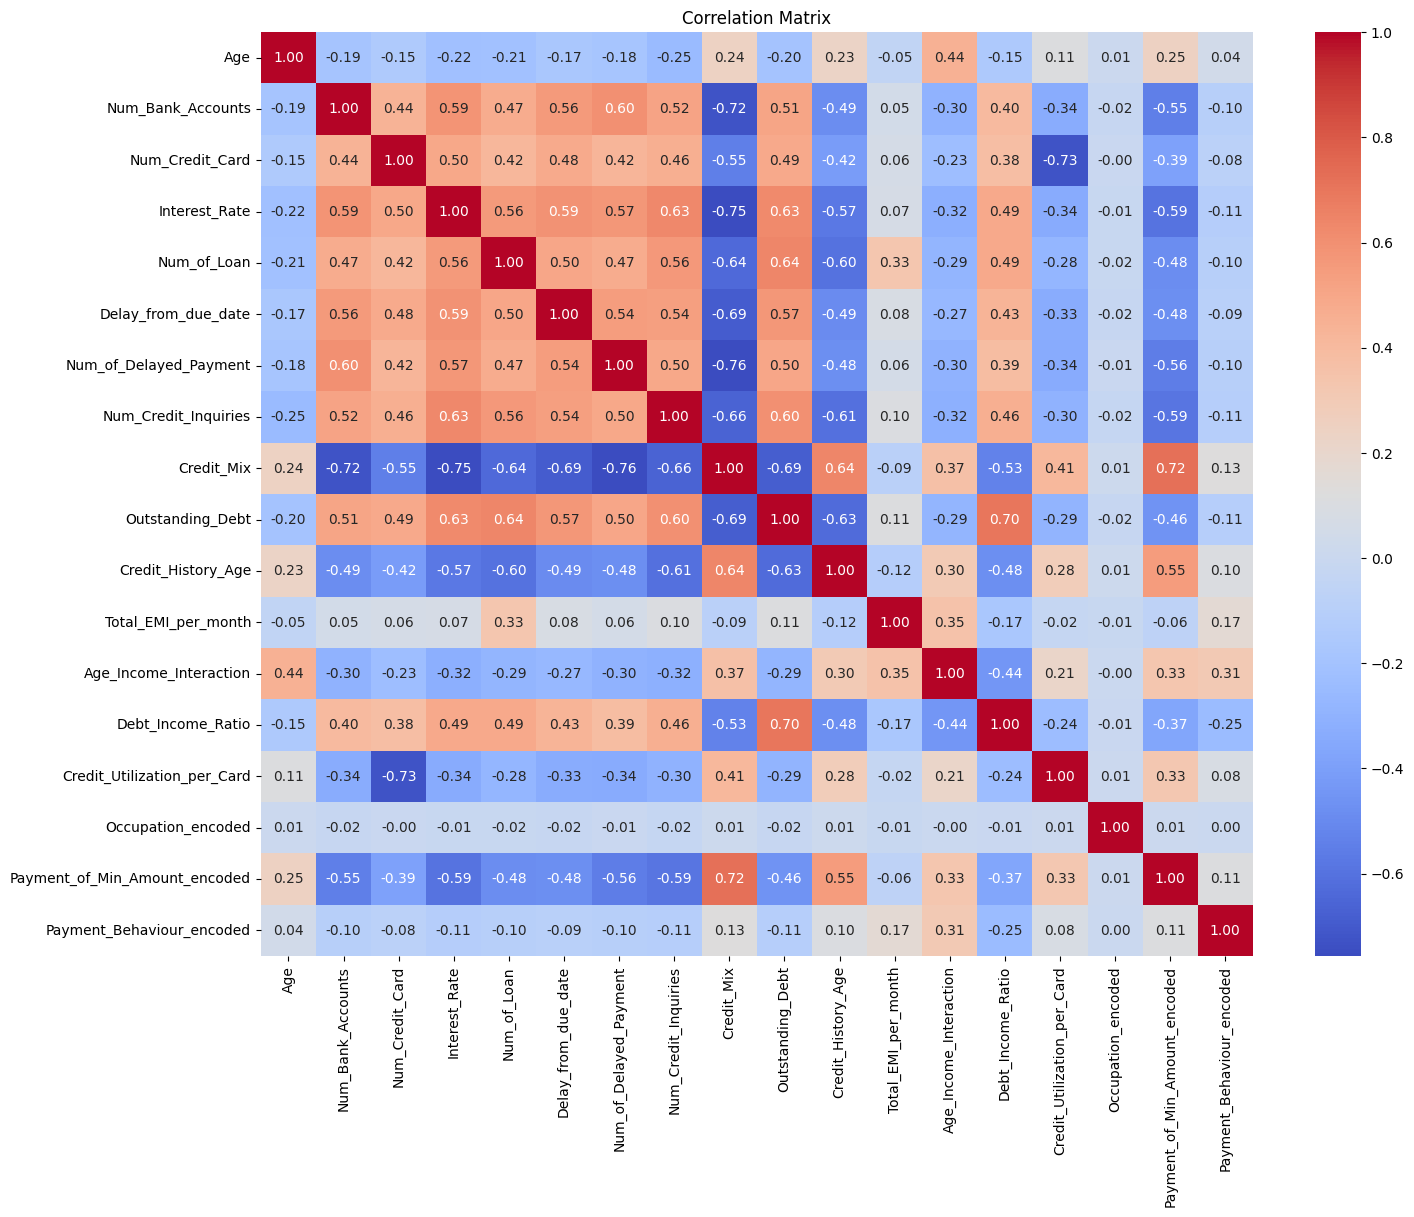

In [ ]:
corr_matrix = X_train.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature Selection

## SelectKBest with F-statistics

In [ ]:
fS = SelectKBest(k='all', score_func=f_regression)
fS.fit(X_train, y_train.values.ravel())

top_feature_indices = fS.get_support(indices=True)
top_feature_names = X_train.columns[top_feature_indices]

top_f_stats = fS.scores_[top_feature_indices]
top_p_values = fS.pvalues_[top_feature_indices]

results_df = pd.DataFrame({'Feature': top_feature_names, 'F-Statistic': top_f_stats, 'p-value': top_p_values})
results_df_sorted = results_df.sort_values(by='F-Statistic', ascending=False)

print(results_df_sorted.to_string(index=False))

                      Feature  F-Statistic       p-value
                   Credit_Mix 23080.025001  0.000000e+00
                Interest_Rate 21636.308858  0.000000e+00
         Num_Credit_Inquiries 16295.062745  0.000000e+00
          Delay_from_due_date 16058.155403  0.000000e+00
Payment_of_Min_Amount_encoded 14458.946105  0.000000e+00
              Num_Credit_Card 13714.643038  0.000000e+00
            Num_Bank_Accounts 12333.853898  0.000000e+00
           Credit_History_Age 12281.550949  0.000000e+00
             Outstanding_Debt 12147.915731  0.000000e+00
       Num_of_Delayed_Payment 11155.115463  0.000000e+00
                  Num_of_Loan 10396.519895  0.000000e+00
  Credit_Utilization_per_Card  9732.814137  0.000000e+00
            Debt_Income_Ratio  7129.664486  0.000000e+00
       Age_Income_Interaction  3959.870424  0.000000e+00
                          Age  1819.247862  0.000000e+00
    Payment_Behaviour_encoded  1017.899891 9.085565e-222
           Occupation_encoded  

## SelectKBest with mutual_info_regression

In [ ]:
fS = SelectKBest(k='all', score_func=mutual_info_regression)
fS.fit(X_train, y_train.values.ravel())

selected_features_indices = fS.get_support(indices=True)
selected_features = X_train.columns[selected_features_indices]

mutual_info_scores = fS.scores_
mutual_info_series = pd.Series(mutual_info_scores, index=X_train.columns, name='Mutual Information')

mutual_info_sorted = mutual_info_series[selected_features].sort_values(ascending=False)
print(mutual_info_sorted)

Debt_Income_Ratio                0.583063
Outstanding_Debt                 0.575769
Total_EMI_per_month              0.520437
Age_Income_Interaction           0.475430
Credit_Mix                       0.186319
Interest_Rate                    0.170463
Delay_from_due_date              0.126356
Num_Credit_Inquiries             0.114199
Num_Credit_Card                  0.110451
Payment_of_Min_Amount_encoded    0.107498
Num_Bank_Accounts                0.104972
Credit_History_Age               0.102310
Num_of_Delayed_Payment           0.096156
Credit_Utilization_per_Card      0.088973
Num_of_Loan                      0.088956
Age                              0.027160
Payment_Behaviour_encoded        0.008588
Occupation_encoded               0.003387
Name: Mutual Information, dtype: float64


## Take a Normalize score from both f_regression and mutual_info_regression

In [ ]:
feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Statistic': top_f_stats,
    'Mutual Information': mutual_info_scores
})

scaler = MinMaxScaler()
feature_scores[['F-Statistic', 'Mutual Information']] = scaler.fit_transform(
    feature_scores[['F-Statistic', 'Mutual Information']]
)

feature_scores['Aggregate Score'] = feature_scores['F-Statistic'] + feature_scores['Mutual Information']
feature_scores_sorted = feature_scores.sort_values(by='Aggregate Score', ascending=False)

print(feature_scores_sorted[['Feature', 'F-Statistic', 'Mutual Information', 'Aggregate Score']])

                          Feature  F-Statistic  Mutual Information  \
9                Outstanding_Debt     0.525970            0.987417   
8                      Credit_Mix     1.000000            0.315575   
13              Debt_Income_Ratio     0.308372            1.000000   
3                   Interest_Rate     0.937399            0.288222   
12         Age_Income_Interaction     0.170925            0.814323   
5             Delay_from_due_date     0.695523            0.212134   
7            Num_Credit_Inquiries     0.705795            0.191162   
11            Total_EMI_per_month     0.000000            0.891964   
16  Payment_of_Min_Amount_encoded     0.626179            0.179601   
2                 Num_Credit_Card     0.593905            0.184695   
1               Num_Bank_Accounts     0.534032            0.175244   
10             Credit_History_Age     0.531764            0.170652   
6          Num_of_Delayed_Payment     0.482920            0.160035   
4                   

In [ ]:
X_train = X_train[['Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate', 'Age_Income_Interaction', 'Total_EMI_per_month',
      'Num_Credit_Inquiries', 'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card', 'Num_Bank_Accounts',
      'Credit_History_Age','Num_of_Delayed_Payment']] # Taking the top 13 features based on combined scores (> 0.6)

X_test = X_test[['Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate', 'Age_Income_Interaction', 'Total_EMI_per_month',
      'Num_Credit_Inquiries', 'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card', 'Num_Bank_Accounts',
      'Credit_History_Age','Num_of_Delayed_Payment']] # Taking the top 13 features based on combined scores (> 0.6)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 13), (30000, 13), (70000,), (30000,))

# Data Drift report

In [ ]:
!pip install evidently -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.1/530.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.1/231.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

reference = X_train.copy()
reference['Credit_Score'] = y_train

current = X_test.copy()
current['Credit_Score'] = y_test

report = Report(metrics=[
    DataDriftPreset(),
])

report.run(reference_data=reference, current_data=current)
report

# Training the Model

## Logistic Regression

### Train the model

In [ ]:
def objective_lr(trial):
    params = {
        'C': trial.suggest_float('C', 0.01, 10),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
    }
    model = LogisticRegression(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=30)

[I 2024-07-23 07:21:07,058] A new study created in memory with name: no-name-31c30de5-5868-4925-9b29-fa3e0a096f45
[I 2024-07-23 07:21:12,129] Trial 0 finished with value: 0.5009821934975347 and parameters: {'C': 0.1923189527243878, 'solver': 'lbfgs', 'max_iter': 390}. Best is trial 0 with value: 0.5009821934975347.
[I 2024-07-23 07:21:20,047] Trial 1 finished with value: 0.5009821934975347 and parameters: {'C': 0.5324561747331761, 'solver': 'lbfgs', 'max_iter': 348}. Best is trial 0 with value: 0.5009821934975347.
[I 2024-07-23 07:21:25,723] Trial 2 finished with value: 0.4760141545346439 and parameters: {'C': 5.664123315076786, 'solver': 'liblinear', 'max_iter': 400}. Best is trial 0 with value: 0.5009821934975347.
[I 2024-07-23 07:21:35,000] Trial 3 finished with value: 0.4760141545346439 and parameters: {'C': 7.5087706722868734, 'solver': 'liblinear', 'max_iter': 495}. Best is trial 0 with value: 0.5009821934975347.
[I 2024-07-23 07:21:40,349] Trial 4 finished with value: 0.47601415

In [ ]:
print(f'Best parameters for Logistic Regression: {study_lr.best_params}')

Best parameters for Logistic Regression: {'C': 0.1923189527243878, 'solver': 'lbfgs', 'max_iter': 390}


In [ ]:
lr_model = LogisticRegression(**study_lr.best_params, random_state=42)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.1923189527243878, max_iter=390, random_state=42)

### Make predictions

In [ ]:
y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_lr = f1_score(y_train, y_pred_train_lr, average='weighted')
test_f1_lr = f1_score(y_test, y_pred_test_lr, average='weighted')

print(f'Logistic Regression - Train F1 Score: {train_f1_lr}')
print(f'Logistic Regression - Test F1 Score: {test_f1_lr}')

Logistic Regression - Train F1 Score: 0.5035659851604455
Logistic Regression - Test F1 Score: 0.5011087247571756


---
**Test F1 Score: 0.5011087247571756**
---
---



## Random Forest Classifier

### Train the model

In [ ]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, 50),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }
    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)

[I 2024-07-22 18:33:31,849] A new study created in memory with name: no-name-1d754064-0c62-49ba-93c3-eddde9952570
[I 2024-07-22 18:36:10,954] Trial 0 finished with value: 0.7205891687188194 and parameters: {'n_estimators': 450, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7205891687188194.
[I 2024-07-22 18:37:13,881] Trial 1 finished with value: 0.7366547594310031 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7366547594310031.
[I 2024-07-22 18:38:10,894] Trial 2 finished with value: 0.7664998315735703 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.7664998315735703.
[I 2024-07-22 18:39:13,317] Trial 3 finished with value: 0.6677953748926141 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 2 with value

In [ ]:
print(f'Best parameters for Random Forest: {study_rf.best_params}')

Best parameters for Random Forest: {'n_estimators': 500, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [ ]:
rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=19, min_samples_split=6, n_estimators=500,
                       random_state=42)

### Make predictions

In [ ]:
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_rf = f1_score(y_train, y_pred_train_rf, average='weighted')
test_f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted')

print(f'Random Forest - Train F1 Score: {train_f1_rf}')
print(f'Random Forest - Test F1 Score: {test_f1_rf}')

Random Forest - Train F1 Score: 0.8784941367885503
Random Forest - Test F1 Score: 0.803891947433419


---
**Test F1 Score: 0.803891947433419**
---
---



## HistGradient Boosting Classifier

### Train the model

In [ ]:
def objective_hgb(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_iter': trial.suggest_int('max_iter', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 25),
        'l2_regularization': trial.suggest_float('l2_regularization', 0.0, 1.0)
    }
    model = HistGradientBoostingClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_hgb = optuna.create_study(direction='maximize')
study_hgb.optimize(objective_hgb, n_trials=30)

[I 2024-07-23 07:24:14,096] A new study created in memory with name: no-name-f24a5264-ab37-47f2-9d5b-e6aea0d2190d
[I 2024-07-23 07:25:22,747] Trial 0 finished with value: 0.7942212762573199 and parameters: {'learning_rate': 0.19510503150806816, 'max_iter': 404, 'max_depth': 12, 'min_samples_leaf': 17, 'l2_regularization': 0.7604290591769943}. Best is trial 0 with value: 0.7942212762573199.
[I 2024-07-23 07:26:27,436] Trial 1 finished with value: 0.7942864091753261 and parameters: {'learning_rate': 0.17421585732104808, 'max_iter': 373, 'max_depth': 12, 'min_samples_leaf': 11, 'l2_regularization': 0.5482920977527975}. Best is trial 1 with value: 0.7942864091753261.
[I 2024-07-23 07:27:13,334] Trial 2 finished with value: 0.7861177502476384 and parameters: {'learning_rate': 0.1506637396723059, 'max_iter': 228, 'max_depth': 10, 'min_samples_leaf': 16, 'l2_regularization': 0.11915112398240735}. Best is trial 1 with value: 0.7942864091753261.
[I 2024-07-23 07:27:32,159] Trial 3 finished with

In [ ]:
print(f'Best parameters for Hist Gradient Boosting: {study_hgb.best_params}')

Best parameters for Hist Gradient Boosting: {'learning_rate': 0.12512443947275093, 'max_iter': 468, 'max_depth': 12, 'min_samples_leaf': 20, 'l2_regularization': 0.009617242468669018}


In [ ]:
hgb_model = HistGradientBoostingClassifier(**study_hgb.best_params, random_state=42)
hgb_model.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.009617242468669018,
                               learning_rate=0.12512443947275093, max_depth=12,
                               max_iter=468, random_state=42)

### Make predictions

In [ ]:
y_pred_train_hgb = hgb_model.predict(X_train)
y_pred_test_hgb = hgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_hgb = f1_score(y_train, y_pred_train_hgb, average='weighted')
test_f1_hgb = f1_score(y_test, y_pred_test_hgb, average='weighted')

print(f'Hist Gradient Boosting - Train F1 Score: {train_f1_hgb}')
print(f'Hist Gradient Boosting - Test F1 Score: {test_f1_hgb}')

Hist Gradient Boosting - Train F1 Score: 0.8876390338685654
Hist Gradient Boosting - Test F1 Score: 0.8039847164053968


---
**Test F1 Score: 0.8046645083879631**
---
---



## XGBoost Classifier

### Train the model

In [ ]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    model = xgb.XGBClassifier(**params, random_state=42, use_label_encoder=False)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-07-23 07:56:25,593] A new study created in memory with name: no-name-5cf08b56-c318-4339-a47a-b1a9e8e1ac87
[I 2024-07-23 07:57:55,392] Trial 0 finished with value: 0.8037195390259451 and parameters: {'n_estimators': 441, 'learning_rate': 0.12157525586170147, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.0011004523643207698, 'subsample': 0.7961029218309721, 'colsample_bytree': 0.5719523683121235}. Best is trial 0 with value: 0.8037195390259451.
[I 2024-07-23 07:58:25,132] Trial 1 finished with value: 0.7977059177663709 and parameters: {'n_estimators': 100, 'learning_rate': 0.12446222499818528, 'max_depth': 12, 'min_child_weight': 1, 'gamma': 0.7753716161995778, 'subsample': 0.8416582994813595, 'colsample_bytree': 0.8927599311605293}. Best is trial 0 with value: 0.8037195390259451.
[I 2024-07-23 07:59:25,733] Trial 2 finished with value: 0.8003870858958981 and parameters: {'n_estimators': 325, 'learning_rate': 0.07472390030771917, 'max_depth': 11, 'min_child_weight': 6, 'gamma

In [ ]:
print(f'Best parameters for XGBoost: {study_xgb.best_params}')

Best parameters for XGBoost: {'n_estimators': 369, 'learning_rate': 0.11871439364718739, 'max_depth': 9, 'min_child_weight': 1, 'gamma': 0.35083108341251845, 'subsample': 0.6321030834170198, 'colsample_bytree': 0.6257005005412428}


In [ ]:
xgb_model = xgb.XGBClassifier(**study_xgb.best_params, random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6257005005412428, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.35083108341251845,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11871439364718739,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=369, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Make predictions

In [ ]:
y_pred_train_xgb = xgb_model.predict(X_train)
y_pred_test_xgb = xgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_xgb = f1_score(y_train, y_pred_train_xgb, average='weighted')
test_f1_xgb = f1_score(y_test, y_pred_test_xgb, average='weighted')

print(f'XGBoost - Train F1 Score: {train_f1_xgb}')
print(f'XGBoost - Test F1 Score: {test_f1_xgb}')

XGBoost - Train F1 Score: 0.9229620216403822
XGBoost - Test F1 Score: 0.81298432781966


---
**Test F1 Score: 0.8143030506826616**
---
---



## LightGBM

### Train the model

In [ ]:
def objective_lgb(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMClassifier(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=make_scorer(f1_score, average='weighted')).mean()
    return score

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=30)

[I 2024-07-23 10:59:48,184] A new study created in memory with name: no-name-00b0deb8-5cd7-4f67-9ae9-2ac4f4ce9764


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing ro

[I 2024-07-23 11:01:29,806] Trial 0 finished with value: 0.7795746537240011 and parameters: {'num_leaves': 74, 'learning_rate': 0.03901243552514268, 'n_estimators': 325, 'min_child_samples': 86, 'subsample': 0.7966023937587514, 'colsample_bytree': 0.8144646368057973}. Best is trial 0 with value: 0.7795746537240011.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007862 sec

[I 2024-07-23 11:01:59,626] Trial 1 finished with value: 0.7841320812367305 and parameters: {'num_leaves': 50, 'learning_rate': 0.11217466982062407, 'n_estimators': 197, 'min_child_samples': 26, 'subsample': 0.6732410536237974, 'colsample_bytree': 0.6365457664814915}. Best is trial 1 with value: 0.7841320812367305.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:03:12,700] Trial 2 finished with value: 0.8057594779992223 and parameters: {'num_leaves': 129, 'learning_rate': 0.09013254744125877, 'n_estimators': 375, 'min_child_samples': 34, 'subsample': 0.5819484346475485, 'colsample_bytree': 0.5211593298931791}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008198 sec

[I 2024-07-23 11:04:36,573] Trial 3 finished with value: 0.7868518488604824 and parameters: {'num_leaves': 126, 'learning_rate': 0.028025434344859115, 'n_estimators': 361, 'min_child_samples': 99, 'subsample': 0.8187882166759823, 'colsample_bytree': 0.5817821866775994}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007275 sec

[I 2024-07-23 11:06:19,506] Trial 4 finished with value: 0.8053226304939596 and parameters: {'num_leaves': 242, 'learning_rate': 0.03509700707624112, 'n_estimators': 348, 'min_child_samples': 40, 'subsample': 0.6851487754333129, 'colsample_bytree': 0.5841363502671086}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:07:49,757] Trial 5 finished with value: 0.8015040737202807 and parameters: {'num_leaves': 148, 'learning_rate': 0.17209230934335754, 'n_estimators': 417, 'min_child_samples': 69, 'subsample': 0.5973832427380767, 'colsample_bytree': 0.9727303183535672}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing ro

[I 2024-07-23 11:09:36,446] Trial 6 finished with value: 0.8010798872330078 and parameters: {'num_leaves': 188, 'learning_rate': 0.15642738253172353, 'n_estimators': 425, 'min_child_samples': 75, 'subsample': 0.7095401343924261, 'colsample_bytree': 0.8424478377721851}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007458 sec

[I 2024-07-23 11:10:28,713] Trial 7 finished with value: 0.8012974861453828 and parameters: {'num_leaves': 196, 'learning_rate': 0.0427401602925574, 'n_estimators': 221, 'min_child_samples': 39, 'subsample': 0.8896573565467591, 'colsample_bytree': 0.7444416473757787}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing ro

[I 2024-07-23 11:11:38,922] Trial 8 finished with value: 0.8022123691611215 and parameters: {'num_leaves': 149, 'learning_rate': 0.1827347182033, 'n_estimators': 347, 'min_child_samples': 55, 'subsample': 0.8454837292787551, 'colsample_bytree': 0.9432831405951556}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007414 sec

[I 2024-07-23 11:12:14,381] Trial 9 finished with value: 0.8003859174211314 and parameters: {'num_leaves': 97, 'learning_rate': 0.15923883511453887, 'n_estimators': 208, 'min_child_samples': 85, 'subsample': 0.9550077199511948, 'colsample_bytree': 0.6314505167553818}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing co

[I 2024-07-23 11:12:30,473] Trial 10 finished with value: 0.7841532354075212 and parameters: {'num_leaves': 108, 'learning_rate': 0.08965516081603486, 'n_estimators': 105, 'min_child_samples': 22, 'subsample': 0.5224358323735044, 'colsample_bytree': 0.5028078709414153}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:14:39,503] Trial 11 finished with value: 0.8045691660354933 and parameters: {'num_leaves': 254, 'learning_rate': 0.07913573926512533, 'n_estimators': 477, 'min_child_samples': 46, 'subsample': 0.6094657436838694, 'colsample_bytree': 0.5152578445001657}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013220 sec

[I 2024-07-23 11:16:20,881] Trial 12 finished with value: 0.7853781393805279 and parameters: {'num_leaves': 251, 'learning_rate': 0.01055602666868774, 'n_estimators': 287, 'min_child_samples': 36, 'subsample': 0.5120651664702851, 'colsample_bytree': 0.6818762735891872}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:17:50,790] Trial 13 finished with value: 0.8040034701956176 and parameters: {'num_leaves': 194, 'learning_rate': 0.12339416598811287, 'n_estimators': 403, 'min_child_samples': 53, 'subsample': 0.6361972654808559, 'colsample_bytree': 0.5718663643087087}. Best is trial 2 with value: 0.8057594779992223.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007415 sec

[I 2024-07-23 11:18:59,596] Trial 14 finished with value: 0.8065106134041999 and parameters: {'num_leaves': 222, 'learning_rate': 0.06342218376391281, 'n_estimators': 281, 'min_child_samples': 33, 'subsample': 0.7496091296181668, 'colsample_bytree': 0.7168336687142391}. Best is trial 14 with value: 0.8065106134041999.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012684 sec

[I 2024-07-23 11:19:53,783] Trial 15 finished with value: 0.8059186286373485 and parameters: {'num_leaves': 166, 'learning_rate': 0.06854091550893356, 'n_estimators': 262, 'min_child_samples': 29, 'subsample': 0.762962870934908, 'colsample_bytree': 0.7355420967393864}. Best is trial 14 with value: 0.8065106134041999.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002383 sec

[I 2024-07-23 11:20:59,688] Trial 16 finished with value: 0.8072608582681047 and parameters: {'num_leaves': 217, 'learning_rate': 0.06169918220515854, 'n_estimators': 271, 'min_child_samples': 28, 'subsample': 0.7443031207985351, 'colsample_bytree': 0.7720483771183888}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:21:29,835] Trial 17 finished with value: 0.8008268632760689 and parameters: {'num_leaves': 223, 'learning_rate': 0.0597732925485377, 'n_estimators': 120, 'min_child_samples': 20, 'subsample': 0.7343344134901788, 'colsample_bytree': 0.8393061804044251}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002225 sec

[I 2024-07-23 11:22:37,111] Trial 18 finished with value: 0.8047116279635113 and parameters: {'num_leaves': 217, 'learning_rate': 0.13155937705666254, 'n_estimators': 264, 'min_child_samples': 52, 'subsample': 0.8871643998618616, 'colsample_bytree': 0.7887527266688747}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start 

[I 2024-07-23 11:23:28,521] Trial 19 finished with value: 0.8012954798152908 and parameters: {'num_leaves': 214, 'learning_rate': 0.05530830362231662, 'n_estimators': 184, 'min_child_samples': 64, 'subsample': 0.9862854928347117, 'colsample_bytree': 0.8829909827127049}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012918 sec

[I 2024-07-23 11:24:28,804] Trial 20 finished with value: 0.7728857355898576 and parameters: {'num_leaves': 177, 'learning_rate': 0.011308057198255062, 'n_estimators': 248, 'min_child_samples': 43, 'subsample': 0.7665624831844309, 'colsample_bytree': 0.6836934132938448}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing co

[I 2024-07-23 11:25:29,195] Trial 21 finished with value: 0.8065167176850379 and parameters: {'num_leaves': 166, 'learning_rate': 0.06713948052282229, 'n_estimators': 300, 'min_child_samples': 29, 'subsample': 0.7571936090656229, 'colsample_bytree': 0.7342690393611653}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012449 sec

[I 2024-07-23 11:26:42,811] Trial 22 finished with value: 0.8063878218958255 and parameters: {'num_leaves': 231, 'learning_rate': 0.08096763318726288, 'n_estimators': 300, 'min_child_samples': 31, 'subsample': 0.7507882931726322, 'colsample_bytree': 0.7129089092870524}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing co

[I 2024-07-23 11:27:19,971] Trial 23 finished with value: 0.800699446003712 and parameters: {'num_leaves': 202, 'learning_rate': 0.05583012760476848, 'n_estimators': 158, 'min_child_samples': 27, 'subsample': 0.8563365688205539, 'colsample_bytree': 0.776062945685929}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1444
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008011 sec

[I 2024-07-23 11:28:28,690] Trial 24 finished with value: 0.8051307854697514 and parameters: {'num_leaves': 168, 'learning_rate': 0.09962779052075696, 'n_estimators': 317, 'min_child_samples': 49, 'subsample': 0.799969811387586, 'colsample_bytree': 0.7002518133703844}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007570 sec

[I 2024-07-23 11:29:27,078] Trial 25 finished with value: 0.8067198584519655 and parameters: {'num_leaves': 234, 'learning_rate': 0.0708811531261409, 'n_estimators': 242, 'min_child_samples': 33, 'subsample': 0.6697204014150122, 'colsample_bytree': 0.6510693661768133}. Best is trial 16 with value: 0.8072608582681047.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007688 sec

[I 2024-07-23 11:30:22,077] Trial 26 finished with value: 0.8079809594960162 and parameters: {'num_leaves': 236, 'learning_rate': 0.07243560939909442, 'n_estimators': 237, 'min_child_samples': 20, 'subsample': 0.6790709872602857, 'colsample_bytree': 0.6338263552181995}. Best is trial 26 with value: 0.8079809594960162.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007797 sec

[I 2024-07-23 11:31:16,692] Trial 27 finished with value: 0.8068911197085683 and parameters: {'num_leaves': 239, 'learning_rate': 0.10771830904883072, 'n_estimators': 240, 'min_child_samples': 21, 'subsample': 0.6522149558173588, 'colsample_bytree': 0.6460364083642149}. Best is trial 26 with value: 0.8079809594960162.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007731 sec

[I 2024-07-23 11:31:51,168] Trial 28 finished with value: 0.8068799695283051 and parameters: {'num_leaves': 207, 'learning_rate': 0.1342767062772557, 'n_estimators': 165, 'min_child_samples': 21, 'subsample': 0.6328000772706132, 'colsample_bytree': 0.6158092269197512}. Best is trial 26 with value: 0.8079809594960162.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1442
[LightGBM] [Info] Number of data points in the train set: 56000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243184
[LightGBM] [Info] Start training from score -0.629468
[LightGBM] [Info] Start training from score -1.722267
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007928 sec

[I 2024-07-23 11:32:45,502] Trial 29 finished with value: 0.8064341686172073 and parameters: {'num_leaves': 242, 'learning_rate': 0.10713457271612294, 'n_estimators': 222, 'min_child_samples': 24, 'subsample': 0.5567205194267238, 'colsample_bytree': 0.778057914214173}. Best is trial 26 with value: 0.8079809594960162.


In [ ]:
print(f'Best parameters for LightGBM: {study_lgb.best_params}')

Best parameters for LightGBM: {'num_leaves': 236, 'learning_rate': 0.07243560939909442, 'n_estimators': 237, 'min_child_samples': 20, 'subsample': 0.6790709872602857, 'colsample_bytree': 0.6338263552181995}


In [ ]:
lgb_model = lgb.LGBMClassifier(**study_lgb.best_params, random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243159
[LightGBM] [Info] Start training from score -0.629475
[LightGBM] [Info] Start training from score -1.722287


LGBMClassifier(colsample_bytree=0.6338263552181995,
               learning_rate=0.07243560939909442, n_estimators=237,
               num_leaves=236, random_state=42, subsample=0.6790709872602857)

### Make predictions

In [ ]:
y_pred_train_lgb = lgb_model.predict(X_train)
y_pred_test_lgb = lgb_model.predict(X_test)

### Evaluate the model

In [ ]:
train_f1_lgb = f1_score(y_train, y_pred_train_lgb, average='weighted')
test_f1_lgb = f1_score(y_test, y_pred_test_lgb, average='weighted')

print(f'LightGBM - Train F1 Score: {train_f1_lgb}')
print(f'LightGBM - Test F1 Score: {test_f1_lgb}')

LightGBM - Train F1 Score: 0.9162580275045585
LightGBM - Test F1 Score: 0.8159745432443398


---
**Test F1 Score: 0.8159745432443398**
---
---



The Model with the best score is **LightGBM: {'num_leaves': 236, 'learning_rate': 0.07243560939909442, 'n_estimators': 237, 'min_child_samples': 20, 'subsample': 0.6790709872602857, 'colsample_bytree': 0.6338263552181995}**
---


---


# Create Pipeline

## Create feature_engineering_pipeline


In [ ]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Age_Income_Interaction'] = X['Age'] * X['Annual_Income']
        X['Debt_Income_Ratio'] = X['Outstanding_Debt'] / X['Annual_Income']

        selected_features = [
            'Outstanding_Debt', 'Credit_Mix', 'Debt_Income_Ratio', 'Interest_Rate',
            'Age_Income_Interaction', 'Total_EMI_per_month', 'Num_Credit_Inquiries',
            'Delay_from_due_date', 'Payment_of_Min_Amount_encoded', 'Num_Credit_Card',
            'Num_Bank_Accounts', 'Credit_History_Age', 'Num_of_Delayed_Payment'
        ]

        return X[selected_features]

## Define Model

In [ ]:
model = lgb.LGBMClassifier(
          colsample_bytree=0.6338263552181995,
          learning_rate=0.07243560939909442,
          n_estimators=237,
          num_leaves=236,
          random_state=42,
          subsample=0.6790709872602857
)

## Create the final pipeline

In [ ]:
pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),
    ('model', model)
])

## Load the data

In [ ]:
url = f'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D
To: /content/dataset.csv
100%|██████████| 30.2M/30.2M [00:00<00:00, 39.2MB/s]


In [ ]:
X = data.drop(columns=['Credit_Score'])
y = data['Credit_Score']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.map({'Poor': 0, 'Standard': 1, 'Good': 2}))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Apply CustomEncoder to the data


In [ ]:
class CustomEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Ensure that Credit_Score is numeric for calculations
        X['Credit_Score'] = LabelEncoder().fit_transform(X['Credit_Score'])
        self.occupation_means = X.groupby('Occupation')['Credit_Score'].mean()
        self.payment_of_min_amount_means = X.groupby('Payment_of_Min_Amount')['Credit_Score'].mean()
        self.payment_behaviour_means = X.groupby('Payment_Behaviour')['Credit_Score'].mean()

        self.credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}
        return self

    def transform(self, X):
        X = X.copy()
        X['Occupation_encoded'] = X['Occupation'].map(self.occupation_means)
        X['Payment_of_Min_Amount_encoded'] = X['Payment_of_Min_Amount'].map(self.payment_of_min_amount_means)
        X['Payment_Behaviour_encoded'] = X['Payment_Behaviour'].map(self.payment_behaviour_means)

        X.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour'], axis=1, inplace=True)

        X['Credit_Mix'] = X['Credit_Mix'].map(self.credit_mix_map)

        return X

In [ ]:
custom_encoder = CustomEncoder()
custom_encoder.fit(pd.concat([X_train, pd.Series(y_train, name='Credit_Score')], axis=1))

CustomEncoder()

In [ ]:
X_train = custom_encoder.transform(X_train)
X_test = custom_encoder.transform(X_test)

## Fit the data into the pipeline

In [ ]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 13
[LightGBM] [Info] Start training from score -1.243159
[LightGBM] [Info] Start training from score -0.629475
[LightGBM] [Info] Start training from score -1.722287


Pipeline(steps=[('feature_engineering', FeatureEngineering()),
                ('model',
                 LGBMClassifier(colsample_bytree=0.6338263552181995,
                                learning_rate=0.07243560939909442,
                                n_estimators=237, num_leaves=236,
                                random_state=42,
                                subsample=0.6790709872602857))])

In [ ]:
drive.mount('/content/drive')
joblib.dump(pipeline, '/content/drive/My Drive/best_pipeline_credit.joblib')

Mounted at /content/drive


['/content/drive/My Drive/best_pipeline_credit.joblib']

## Model Performance

In [ ]:
best_model_path = '/content/drive/My Drive/best_pipeline_credit.joblib'
model_pipeline = joblib.load(best_model_path)

y_pred = model_pipeline.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Weighted F1 Score: {weighted_f1}')

Accuracy: 0.8159333333333333
Weighted F1 Score: 0.8159745432443398


Text(0.5, 1.05, 'Confusion_matrix')

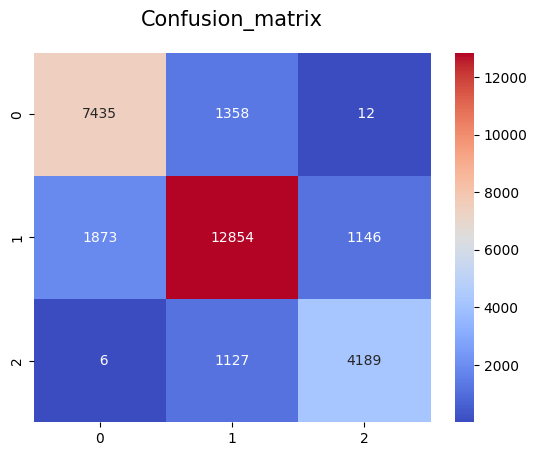

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True,fmt='3.0f',cmap="coolwarm")
plt.title('Confusion_matrix', y=1.05, size=15)

# Make new predictions using Streamlit

In [ ]:
!pip install streamlit -q
!npm install -g localtunnel -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00

added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
%%writefile credit_score_prediction.py
import gdown
import streamlit as st
import joblib
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class CustomEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mean_encoding_dict=None):
        self.mean_encoding_dict = mean_encoding_dict

    def fit(self, X, y=None):
        X = X.copy()

        X['Credit_Score'] = LabelEncoder().fit_transform(X['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2}))

        self.mean_encoding_dict = {
            'Occupation': X.groupby('Occupation')['Credit_Score'].mean().to_dict(),
            'Payment_of_Min_Amount': X.groupby('Payment_of_Min_Amount')['Credit_Score'].mean().to_dict(),
            'Payment_Behaviour': X.groupby('Payment_Behaviour')['Credit_Score'].mean().to_dict()
        }

        self.credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2}

        return self

    def transform(self, X):
        X = X.copy()

        X['Occupation_encoded'] = X['Occupation'].map(self.mean_encoding_dict['Occupation'])
        X['Payment_of_Min_Amount_encoded'] = X['Payment_of_Min_Amount'].map(self.mean_encoding_dict['Payment_of_Min_Amount'])
        X['Payment_Behaviour_encoded'] = X['Payment_Behaviour'].map(self.mean_encoding_dict['Payment_Behaviour'])

        X['Credit_Mix_encoded'] = X['Credit_Mix'].map(self.credit_mix_map)

        X.drop(['Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Mix'], axis=1, inplace=True)

        return X

url = 'https://drive.google.com/uc?id=1SHSBrl9T7qDoiQThluyfBJyPBg49iz0D'
output = 'dataset.csv'
gdown.download(url, output, quiet=False)
data = pd.read_csv(output)

label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'].map({'Poor': 0, 'Standard': 1, 'Good': 2}))

custom_encoder = CustomEncoder()
data = custom_encoder.fit_transform(data)

pipeline = joblib.load('/content/drive/My Drive/best_pipeline_credit.joblib')

st.title('Credit Score Prediction')

ID = st.number_input('ID', min_value=1, value=1)
Customer_ID = st.number_input('Customer_ID', min_value=1, value=1)
Month = st.number_input('Month', min_value=1, max_value=8, value=7)
Name = st.text_input('Name', 'John Doe')
Age = st.number_input('Age', min_value=14, max_value=100, value=30)
SSN = st.text_input('SSN', '123-45-6789')
Occupation = st.text_input('Occupation', 'Engineer')
Annual_Income = st.number_input('Annual_Income', min_value=1000, value=50000)
Monthly_Inhand_Salary = st.number_input('Monthly_Inhand_Salary', min_value=100, value=4000)
Num_Bank_Accounts = st.number_input('Num_Bank_Accounts', min_value=1, value=2)
Num_Credit_Card = st.number_input('Num_Credit_Card', min_value=0, value=1)
Interest_Rate = st.number_input('Interest_Rate', min_value=1.0, format="%.2f", value=5.0)
Num_of_Loan = st.number_input('Num_of_Loan', min_value=0, value=1)
Type_of_Loan = st.selectbox('Type_of_Loan', ['Personal', 'Home', 'Car', 'Education'])
Delay_from_due_date = st.number_input('Delay_from_due_date', min_value=0, value=0)
Num_of_Delayed_Payment = st.number_input('Num_of_Delayed_Payment', min_value=0, value=1)
Changed_Credit_Limit = st.number_input('Changed_Credit_Limit', min_value=0, value=5000)
Num_Credit_Inquiries = st.number_input('Num_Credit_Inquiries', min_value=0, value=1)
Credit_Mix = st.selectbox('Credit_Mix', ['Bad', 'Standard', 'Good'])
Outstanding_Debt = st.number_input('Outstanding_Debt', min_value=0, value=1000)
Credit_Utilization_Ratio = st.number_input('Credit_Utilization_Ratio', min_value=20.0, format="%.2f", value=30)
Credit_History_Age = st.number_input('Credit_History_Age', min_value=0, value=5)
Payment_of_Min_Amount = st.selectbox('Payment_of_Min_Amount', ['Yes', 'No'])
Total_EMI_per_month = st.number_input('Total_EMI_per_month', min_value=0, value=300)
Amount_invested_monthly = st.number_input('Amount_invested_monthly', min_value=0, value=1000)
Payment_Behaviour = st.selectbox('Payment_Behaviour', ['Low', 'Medium', 'High'])
Monthly_Balance = st.number_input('Monthly_Balance', min_value=-5000, value=1000)

new_data = pd.DataFrame({
    'ID': [ID],
    'Customer_ID': [Customer_ID],
    'Month': [Month],
    'Name': [Name],
    'Age': [Age],
    'SSN': [SSN],
    'Occupation': [Occupation],
    'Annual_Income': [Annual_Income],
    'Monthly_Inhand_Salary': [Monthly_Inhand_Salary],
    'Num_Bank_Accounts': [Num_Bank_Accounts],
    'Num_Credit_Card': [Num_Credit_Card],
    'Interest_Rate': [Interest_Rate],
    'Num_of_Loan': [Num_of_Loan],
    'Type_of_Loan': [Type_of_Loan],
    'Delay_from_due_date': [Delay_from_due_date],
    'Num_of_Delayed_Payment': [Num_of_Delayed_Payment],
    'Changed_Credit_Limit': [Changed_Credit_Limit],
    'Num_Credit_Inquiries': [Num_Credit_Inquiries],
    'Credit_Mix': [Credit_Mix],
    'Outstanding_Debt': [Outstanding_Debt],
    'Credit_Utilization_Ratio': [Credit_Utilization_Ratio],
    'Credit_History_Age': [Credit_History_Age],
    'Payment_of_Min_Amount': [Payment_of_Min_Amount],
    'Total_EMI_per_month': [Total_EMI_per_month],
    'Amount_invested_monthly': [Amount_invested_monthly],
    'Payment_Behaviour': [Payment_Behaviour],
    'Monthly_Balance': [Monthly_Balance]
})

new_data_transformed = custom_encoder.transform(new_data)

if st.button('Predict Score'):
    predicted_score = pipeline.predict(new_data_transformed)
    st.markdown(f"""
        <div style="display: flex; justify-content: center; align-items: center; padding: 10px; border: 2px solid #4CAF50; border-radius: 10px; background-color: #f9f9f9; margin-top: 20px;">
            <h2 style="color: #4CAF50;">The predicted Credit Score is: {label_encoder.inverse_transform(predicted_score)[0]}</h2>
        </div>
    """, unsafe_allow_html=True)

Writing credit_score_prediction.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.247.60.121


In [ ]:
import subprocess

subprocess.Popen(["streamlit", "run", "credit_score_prediction.py"])

!npx localtunnel --port 8501

^C
